# Book to evaluate Weighted Standard Distance

## imports

In [1]:
import os
import sys
import re

code_path = os.path.dirname(os.getcwd())
sys.path.append(code_path)

import warnings
import json
from os.path import join as ospj

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, chi2
from scipy.io import loadmat
from tqdm import tqdm

import tools

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

from sklearn import *
import statsmodels.api as sm
from scipy.stats import pearsonr
from confidenceinterval import roc_auc_score

os.environ['PYTHONWARNINGS']='ignore' # for parallel

warnings.filterwarnings("ignore")
sns.set_theme(
    context="notebook",
    palette="deep",
    style="white",
    rc={
        "axes.spines.right": True,
        "axes.spines.top": True,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

### set Params

In [2]:
with open("../config.json", "rb") as f:
    config = json.load(f)
repo_path = config["repositoryPath"]
metadata_path = ospj(repo_path, "ieeg-metadata")
data_path = ospj(repo_path, "data")
figpath = config["figure_path"]

In [3]:
PreImplantData = pd.read_excel(
    ospj(metadata_path, "Preimplant data-final.xlsx"), index_col=2
)

dropcols = [
    "Done?",
    "annotator",
    "Notes",
    "mri_lesion_ifother",
    "spect_lesion_yn",
    "SOZ electrode",
    "SOZ localization",
    "confidence",
    "who_clinician",
    "Notes_clinician",
    "region_clinician",
    "lateralization_clinician",
]
PreImplantData.drop(columns=dropcols, inplace=True)
PreImplantData = PreImplantData.applymap(
    lambda s: s.lower().strip() if type(s) == str else s
)
PreImplantData.dropna(how="all", inplace=True)
# for these cols, NA means no spikes; for all other cols NA means test not performed
PreImplantData[["eeg_inter_lat", "eeg_inter_loc", "eeg_ictal_lat", "eeg_ictal_loc"]] = (
    PreImplantData[
        ["eeg_inter_lat", "eeg_inter_loc", "eeg_ictal_lat", "eeg_ictal_loc"]
    ].fillna("none")
)


PreImplantData = PreImplantData.astype("category")

# define target:
target_col = "postimplant_soz"
PreImplantData = PreImplantData.drop(
    PreImplantData[PreImplantData[target_col].isna()].index
)
Y = (PreImplantData[target_col] == "unifocal").astype(int).rename("focality")  # binary
# Y = PreImplantData[target_col].rename('focality') #categorical, multiclass
Y

name
HUP100    0
HUP101    0
HUP102    0
HUP105    1
HUP106    1
         ..
HUP094    1
HUP096    0
HUP097    0
HUP098    1
HUP227    1
Name: focality, Length: 135, dtype: int64

In [4]:
outcomes = pd.read_excel(
    ospj(
        data_path,
        "CNTSurgicalRepositor-Erinbasicdemographic_DATA_LABELS_2022-10-31_1508.xlsx",
    )
)
outcomes.index = (
    outcomes["HUP Number"].map(lambda x: "HUP" + str(x).zfill(3)).rename("name")
)

In [5]:
all_procs = pd.get_dummies(outcomes["Type of Surgery:"].str.split(",").explode())
all_procs = all_procs.groupby(all_procs.index).sum().rename_axis("surgery", axis=1)
Surgery = (
    all_procs["Laser ablation"]
    | all_procs["Resection with intracranial implant"]
    | all_procs["Resection without intracranial implant"]
)
Device = all_procs["VNS"] | all_procs["DBS"] | all_procs["RNS"]
Other = all_procs["Other"]
type_of_proc = pd.concat(
    [Surgery, Device, Other], axis=1, keys=["surgery", "device", "other"]
)

In [6]:
# what procedure did they get
type_of_proc = type_of_proc.apply(
    lambda x: (
        "both"
        if ((x["surgery"]) & (x["device"]))
        else "surgery" if x["surgery"] else "device" if x["device"] else "none"
    ),
    axis=1,
)

In [7]:
bands = [
    [0.5, 4],  # delta
    [4, 8],  # theta
    [8, 12],  # alpha
    [12, 30],  # beta
    [30, 80],  # gamma
    [0.5, 80],  # broad
]
band_names = ["delta", "theta", "alpha", "beta", "gamma", "broad"]
N_BANDS = len(bands)

## Replicate 5sense

In [8]:
FiveSensePreds = [
    "mri_lesion_yn",
    "mri_lesion_lat",
    "mri_lesion_loc",
    "eeg_inter_lat",
    "eeg_inter_loc",
    "neuropsy_lat",
    "semiology_loc",
    "eeg_ictal_lat",
    "eeg_ictal_loc",
]
X = PreImplantData[FiveSensePreds]

In [9]:
# define predictors:
FiveSensePreds = [
    "mri_lesion_yn",
    "mri_lesion_lat",
    "mri_lesion_loc",
    "eeg_inter_lat",
    "eeg_inter_loc",
    "neuropsy_lat",
    "semiology_loc",
    "eeg_ictal_lat",
    "eeg_ictal_loc",
]
X = PreImplantData[FiveSensePreds]
# reformat data into their schema
MRIdict = {
    "condition": [
        X["mri_lesion_yn"] == "n",
        X["mri_lesion_lat"].isin(["left", "right", "other"])
        & X["mri_lesion_loc"].isin(["temporal", "frontal", "other"]),
    ],
    "choice": ["nolesion", "focal"],
    "default": "nonfocal",
}


interDict = {
    "condition": [
        (X["eeg_inter_lat"] == "none") & (X["eeg_inter_loc"] == "none"),
        X["eeg_inter_lat"] == "bilateral",
    ],
    "choice": ["nospike", "bilateral"],
    "default": "allothers",
}
SemioDict = {
    "condition": [X["semiology_loc"].isin(["temporal", "frontal", "other"])],
    "choice": ["localizing"],
    "default": "nonlocalizing",
}
NeuroPsyDict = {
    "condition": [
        X["neuropsy_lat"].isin(["left", "right"]),
        X["neuropsy_lat"].isin(["bilateral", "multifocal"]),
    ],
    "choice": ["localizing", "nonlocalizing"],
    "default": "no_deficit",
}
ictalDict = {
    "condition": [
        (X["eeg_ictal_lat"].isin(["left", "right"]))
        & (X["eeg_ictal_loc"].isin(["temporal", "frontal", "other"])),
        (X["eeg_ictal_lat"] == "bilateral")
        & (~X["eeg_ictal_loc"].isin(["unclear", "broad", "multifocal"])),
    ],
    "choice": ["focal", "bilateral"],
    "default": "none",
}


X["MRI"] = np.select(
    MRIdict["condition"], MRIdict["choice"], default=MRIdict["default"]
)
X["InterEEG"] = np.select(
    interDict["condition"], interDict["choice"], default=interDict["default"]
)
X["Semio"] = np.select(
    SemioDict["condition"], SemioDict["choice"], default=SemioDict["default"]
)
X["Ictal"] = np.select(
    ictalDict["condition"], ictalDict["choice"], default=ictalDict["default"]
)
X["NeuroPsy"] = np.select(
    NeuroPsyDict["condition"], NeuroPsyDict["choice"], default=NeuroPsyDict["default"]
)
FiveSenseDf = pd.get_dummies(X[["MRI", "InterEEG", "Semio", "Ictal", "NeuroPsy"]])
FiveSenseDf

/tmp/ipykernel_43284/1258521259.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["MRI"] = np.select(
/tmp/ipykernel_43284/1258521259.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["InterEEG"] = np.select(
/tmp/ipykernel_43284/1258521259.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,MRI_focal,MRI_nolesion,MRI_nonfocal,InterEEG_allothers,InterEEG_bilateral,InterEEG_nospike,Semio_localizing,Semio_nonlocalizing,Ictal_bilateral,Ictal_focal,Ictal_none,NeuroPsy_localizing,NeuroPsy_no_deficit,NeuroPsy_nonlocalizing
name,,,,,,,,,,,,,,
HUP100,False,True,False,False,True,False,True,False,False,False,True,False,True,False
HUP101,False,True,False,False,False,True,False,True,False,False,True,True,False,False
HUP102,False,True,False,False,True,False,True,False,False,True,False,False,True,False
HUP105,True,False,False,True,False,False,False,True,False,True,False,False,True,False
HUP106,False,True,False,True,False,False,True,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUP094,False,True,False,False,True,False,True,False,False,False,True,False,True,False
HUP096,False,True,False,False,True,False,True,False,True,False,False,False,True,False
HUP097,False,True,False,True,False,False,False,True,False,True,False,True,False,False


In [10]:
weights = np.array(
    [
        0,
        -2.2636,
        -2.1494,
        1.1807,
        0,
        1.8056,
        0.8489,
        0,
        0,
        0.8442,
        -0.8124,
        0,
        1.15,
        -0.26,
    ]
)


for i in range(len(weights)):
    print(FiveSenseDf.columns[i], " : ", weights[i])

MRI_focal  :  0.0
MRI_nolesion  :  -2.2636
MRI_nonfocal  :  -2.1494
InterEEG_allothers  :  1.1807
InterEEG_bilateral  :  0.0
InterEEG_nospike  :  1.8056
Semio_localizing  :  0.8489
Semio_nonlocalizing  :  0.0
Ictal_bilateral  :  0.0
Ictal_focal  :  0.8442
Ictal_none  :  -0.8124
NeuroPsy_localizing  :  0.0
NeuroPsy_no_deficit  :  1.15
NeuroPsy_nonlocalizing  :  -0.26


In [11]:
score = np.matmul(FiveSenseDf.to_numpy(), weights) - 0.3135

In [12]:
from sklearn import metrics

Text(0, 0.5, 'tpr')

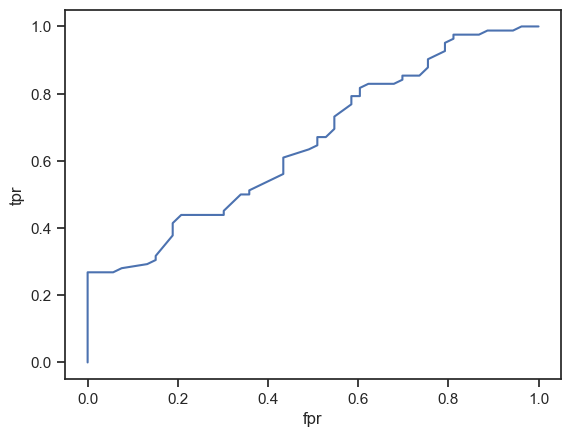

In [13]:
prediction = np.exp(score) / (np.exp(score) + 1)
yhat = prediction > 0.376
fpr, tpr, threshold = metrics.roc_curve(Y, prediction)

In [18]:
FiveSenseScore = (
    pd.DataFrame(score, index=Y.index.rename("patient"), columns=["fivesense"])
    .join(Y)
    .set_index("focality", append=True)
)
FiveSenseScore.to_csv(ospj(data_path, "5_Sense_Score.csv"))

In [19]:
FiveSensePreds = (
    pd.DataFrame(prediction, index=Y.index.rename("patient"), columns=["fivesense"])
    .join(Y)
    .set_index("focality", append=True)
)

## Compile Data

### Get Data
- Norm Atlas
- Patient data
    - bipolar
        - bandpower
            - raw to compare
            - canonical for actual tests
    - electrode locs


In [22]:
norm_logpower = pd.read_pickle(ospj(data_path, "norm_logpower.pkl"))

In [23]:
norm_power = pd.read_pickle(ospj(data_path, "Norm_Power.pkl"))
norm_power

,elec,region,index,x,y,z,patient,band,bandpower
0,0,ctx-lh-middletemporal,1015,-56.0000,-37.0000,-2.000000,1,delta,0.226087
1,0,ctx-lh-middletemporal,1015,-56.0000,-37.0000,-2.000000,1,theta,0.189842
2,0,ctx-lh-middletemporal,1015,-56.0000,-37.0000,-2.000000,1,alpha,0.187283
3,0,ctx-lh-middletemporal,1015,-56.0000,-37.0000,-2.000000,1,beta,0.267728
4,0,ctx-lh-middletemporal,1015,-56.0000,-37.0000,-2.000000,1,gamma,0.129059
...,...,...,...,...,...,...,...,...,...
14551,2425,Right-Hippocampus,53,31.6265,-30.6042,-5.236628,166,theta,0.200189
14552,2425,Right-Hippocampus,53,31.6265,-30.6042,-5.236628,166,alpha,0.172251
14553,2425,Right-Hippocampus,53,31.6265,-30.6042,-5.236628,166,beta,0.203167
14554,2425,Right-Hippocampus,53,31.6265,-30.6042,-5.236628,166,gamma,0.168388


In [24]:
AllCoords = pd.read_pickle(ospj(data_path, "AllCoords.pkl"))
DropLabels = [
    "Unknown",
    "Left-Cerebral-White-Matter",
    "Left-Lateral-Ventricle",
    "Left-Inf-Lat-Vent",
    "Left-Cerebellum-White-Matter",
    "Left-Cerebellum-Cortex",
    "3rd-Ventricle",
    "4th-Ventricle",
    "Brain-Stem",
    "CSF",
    "Left-choroid-plexus",
    "Right-Cerebral-White-Matter",
    "Right-Lateral-Ventricle",
    "Right-Inf-Lat-Vent",
    "Right-Cerebellum-White-Matter",
    "Right-Cerebellum-Cortex",
    "Right-choroid-plexus",
    "WM-hypointensities",
    "Optic-Chiasm",
    "CC_Posterior",
    "CC_Mid_Posterior",
    "CC_Central",
    "CC_Mid_Anterior",
    "CC_Anterior",
    "ctx-lh-unknown",
    "ctx-lh-corpuscallosum",
    "ctx-rh-unknown",
    "ctx-rh-corpuscallosum",
    "Left-VentralDC",
    "Left-vessel",
    "Right-VentralDC",
    "Right-vessel",
]
LUT = pd.read_csv(
    ospj(metadata_path, "roiDKT.csv"),
).rename(columns={"Lobe": "lobe"})
LUT["roi"] = LUT["Abbvr"].map(lambda x: x[: int(x.find("_"))])
LUT["lat"] = LUT["isSideLeft"].map({1: "left", 0: "right"})

In [25]:
AllCoords

,name,x,y,z,index,label,patient,x_mm,y_mm,z_mm,soz
0,DAMF01,134.1900,178.560,77.6144,0.0,NaN,HUP100,3.26125,54.0116,4.68412,NaN
1,DAMF02,129.2440,178.703,79.7715,1014.0,ctx-lh-medialorbitofrontal,HUP100,-1.56948,54.1511,6.84120,NaN
2,DAMF03,124.2970,178.846,81.9286,1014.0,ctx-lh-medialorbitofrontal,HUP100,-6.40021,54.2906,8.99829,NaN
3,DAMF04,119.7960,178.952,83.0659,2.0,Left-Cerebral-White-Matter,HUP100,-10.79540,54.3941,10.13560,NaN
4,DMPF01,135.7920,172.845,98.1670,0.0,NaN,HUP100,4.82568,48.4305,25.23670,NaN
...,...,...,...,...,...,...,...,...,...,...,...
97,SF02,78.7152,210.106,107.9970,1028.0,ctx-lh-superiorfrontal,HUP097,-28.38030,69.8737,5.88712,0.0
98,SF03,72.0570,204.758,114.8510,0.0,NaN,HUP097,-34.38220,65.0639,12.05910,0.0
99,SF04,68.1408,195.919,120.4440,0.0,NaN,HUP097,-37.91240,57.1156,17.09510,0.0
100,SF05,65.4665,186.763,124.9740,1027.0,ctx-lh-rostralmiddlefrontal,HUP097,-40.32320,48.8817,21.17440,0.0


In [26]:
ChansToGet = AllCoords.dropna(subset="label")
ChansToGet = ChansToGet[
    (~ChansToGet["label"].isin(DropLabels))
    & (ChansToGet["label"].isin(norm_power["region"]))
    & (ChansToGet["patient"].isin(Y.index))
]
ChansToGet

,name,x,y,z,index,label,patient,x_mm,y_mm,z_mm,soz
1,DAMF02,129.2440,178.7030,79.7715,1014.0,ctx-lh-medialorbitofrontal,HUP100,-1.56948,54.1511,6.84120,NaN
2,DAMF03,124.2970,178.8460,81.9286,1014.0,ctx-lh-medialorbitofrontal,HUP100,-6.40021,54.2906,8.99829,NaN
5,DMPF02,130.7590,173.2580,97.3369,1026.0,ctx-lh-rostralanteriorcingulate,HUP100,-0.08924,48.8342,24.40660,NaN
8,DSC01,132.7000,166.2780,82.6204,2026.0,ctx-rh-rostralanteriorcingulate,HUP100,1.80600,42.0171,9.69015,NaN
9,DSC02,128.1110,167.9310,83.8938,1026.0,ctx-lh-rostralanteriorcingulate,HUP100,-2.67600,43.6314,10.96350,NaN
...,...,...,...,...,...,...,...,...,...,...,...
92,PT01,53.5568,61.4892,68.5586,1011.0,ctx-lh-lateraloccipital,HUP097,-51.05910,-63.7749,-29.62630,0.0
94,PT03,40.9364,78.4105,76.0094,1015.0,ctx-lh-middletemporal,HUP097,-62.43570,-48.5579,-22.91710,1.0
97,SF02,78.7152,210.1060,107.9970,1028.0,ctx-lh-superiorfrontal,HUP097,-28.38030,69.8737,5.88712,0.0
100,SF05,65.4665,186.7630,124.9740,1027.0,ctx-lh-rostralmiddlefrontal,HUP097,-40.32320,48.8817,21.17440,0.0


In [27]:
AllPtPxx = pd.read_pickle(ospj(data_path, "AllPtPxxBipolar.pkl"))
AllPtPxx = AllPtPxx  # .xs()
AllPtPxx

bandpower
patient period     clip channel freq             
HUP064  interictal 13   LF01    0.5    623.845517
                                1.0   1788.186839
                                1.5   2396.297966
                                2.0   2012.354367
                                2.5   1571.040703
...                                           ...
HUP218  interictal 19   RL11    78.0     0.000638
                                78.5     0.000507
                                79.0     0.000451
                                79.5     0.000478
                                80.0     0.000559

[35910400 rows x 1 columns]

In [28]:
NormNxx = pd.read_pickle(ospj(data_path, "NormAllConnect.pkl"))

In [29]:
NormNxx = NormNxx[NormNxx.reset_index("num")["num"] > 8]
NormNxx = NormNxx[~(NormNxx["std"] == 0).any(axis=1)]
NormNxx = NormNxx.stack("band").reset_index("num")
# symmetric indices for all connections
AllNormConns = list(
    NormNxx.reset_index()[["roi_from", "roi_to"]].itertuples(index=False, name=None)
)

/tmp/ipykernel_43284/1043981381.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  NormNxx = NormNxx[NormNxx.reset_index("num")["num"] > 8]


In [30]:
AllPtNxx = pd.read_pickle(ospj(data_path, "AllPtNxxBipolar.pkl")).reset_index()

In [31]:
# find combos where both channel 1 and channel 2 are in ROIs we care about
AllConnCombos = pd.merge(
    AllPtNxx[["patient", "channel_1", "channel_2"]].drop_duplicates(),
    ChansToGet[["patient", "name", "label"]].drop_duplicates(),
    left_on=["patient", "channel_1"],
    right_on=["patient", "name"],
).drop("name", axis=1)
# did it in two merges to use the suffixes
AllConnCombos = pd.merge(
    AllConnCombos,
    ChansToGet[["patient", "name", "label"]].drop_duplicates(),
    left_on=["patient", "channel_2"],
    right_on=["patient", "name"],
    suffixes=("_1", "_2"),
).drop("name", axis=1)
# filter patient channel combinations for only those in Normative atlas
AllConnCombos = AllConnCombos[
    [
        (conn in AllNormConns)
        for conn in list(zip(AllConnCombos.label_1, AllConnCombos.label_2))
    ]
]
# merge all data to get roi labels
AllPtNxx = AllPtNxx.merge(AllConnCombos)

In [32]:
mannwhitneyu(
    *[
        group
        for i, group in AllPtNxx.groupby("patient")
        .apply(lambda x: len(np.unique(x[["channel_1", "channel_2"]].values.ravel())))
        .to_frame()
        .join(Y)
        .groupby("focality")
    ]
)

MannwhitneyuResult(statistic=array([1405.5,    0. ]), pvalue=array([9.55253416e-02, 1.59116168e-23]))

### filter channels

In [33]:
AllChans = pd.merge(
    AllPtPxx.reset_index(),
    ChansToGet,
    left_on=["patient", "channel"],
    right_on=["patient", "name"],
)

In [34]:
AllChans = AllChans.merge(Y, left_on="patient", right_index=True)

In [35]:
AllChans[["patient", "channel", "soz"]].drop_duplicates()["soz"].value_counts()

soz
0.0    3591
1.0     454
Name: count, dtype: int64

In [36]:
all_power_bands = AllChans.groupby(
    ["patient", "clip", "channel", "period", "focality"], group_keys=True
)[["freq", "bandpower"]].apply(lambda x: tools.format_bandpower(x))
all_power_bands
all_power_bands.to_pickle(ospj(data_path, "PxxByBandBipolar.pkl"))
# all_power_bands = pd.read_pickle(ospj(data_path,'PxxByBandBipolar.pkl'))

/mnt/leif/littlab/users/rsg20/Weighted_Distance/code/tools/format_bandpower.py:37: RuntimeWarning: invalid value encountered in divide
  pxx_bands[:-1] = pxx_bands[:-1] / np.sum(pxx_bands[:-1], axis=0)


In [37]:
all_power_bands

band                                         delta     theta     alpha   
patient clip channel period     focality                                 
HUP064  0    LF03    interictal 1         0.276064  0.234523  0.182128  \
             LF04    interictal 1         0.281295  0.229606  0.179892   
             LG01    interictal 1         0.242887  0.221380  0.192845   
             LG03    interictal 1         0.243821  0.219110  0.192272   
             LG05    interictal 1         0.254559  0.216221  0.182639   
...                                            ...       ...       ...   
HUP218  19   RK03    interictal 1         0.217158  0.198701  0.214456   
             RL04    interictal 1         0.240460  0.203639  0.217499   
             RL07    interictal 1         0.248905  0.212551  0.195447   
             RL09    interictal 1         0.258643  0.219506  0.198391   
             RL10    interictal 1         0.216352  0.193906  0.190236   

band                                          beta     gamma     broad  
patient clip channel period     focality                                
HUP064  0    LF03    interictal 1         0.180839  0.126446  4.014028  
             LF04    interictal 1         0.180842  0.128365  3.831057  
             LG01    interictal 1         0.201822  0.141066  3.370843  
             LG03    interictal 1         0.203280  0.141518  3.707494  
             LG05    interictal 1         0.205731  0.140849  3.728753  
...                                            ...       ...       ...  
HUP218  19   RK03    interictal 1         0.235731  0.133955  2.312299  
             RL04    interictal 1         0.217937  0.120465  2.677160  
             RL07    interictal 1         0.203901  0.139196  2.931101  
             RL09    interictal 1         0.195856  0.127604  2.977548  
             RL10    interictal 1         0.242671  0.156835  1.838062  

[82000 rows x 6 columns]

In [38]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

## Main

### predictors of focality

#### Zscore bandpower to norm atlas by ROI

In [39]:
Mean = norm_power.groupby(["region", "band"])["bandpower"].mean().rename("mean")
Std = norm_power.groupby(["region", "band"])["bandpower"].std().rename("std")
NormRois = pd.concat([Mean, Std], axis=1)

In [40]:
def getZscore(x, l, b):
    return (x - NormRois.loc[l, b]["mean"]) / NormRois.loc[l, b]["std"]

In [41]:
AllBandChans = pd.merge(
    all_power_bands.stack("band").rename("bandpower").reset_index(),
    ChansToGet,
    left_on=["patient", "channel"],
    right_on=["patient", "name"],
)
AllBandChans["focality"] = AllBandChans["patient"].map(lambda x: Y[x])
AllBandChans

,patient,clip,channel,period,focality,band,bandpower,name,x,y,z,index,label,x_mm,y_mm,z_mm,soz
0,HUP064,0,LF03,interictal,1,delta,0.276064,LF03,117.719,197.171,83.0532,1028.0,ctx-lh-superiorfrontal,-7.02999,75.5083,25.4570,0.0
1,HUP064,0,LF03,interictal,1,theta,0.234523,LF03,117.719,197.171,83.0532,1028.0,ctx-lh-superiorfrontal,-7.02999,75.5083,25.4570,0.0
2,HUP064,0,LF03,interictal,1,alpha,0.182128,LF03,117.719,197.171,83.0532,1028.0,ctx-lh-superiorfrontal,-7.02999,75.5083,25.4570,0.0
3,HUP064,0,LF03,interictal,1,beta,0.180839,LF03,117.719,197.171,83.0532,1028.0,ctx-lh-superiorfrontal,-7.02999,75.5083,25.4570,0.0
4,HUP064,0,LF03,interictal,1,gamma,0.126446,LF03,117.719,197.171,83.0532,1028.0,ctx-lh-superiorfrontal,-7.02999,75.5083,25.4570,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462042,HUP218,19,RL10,interictal,1,theta,0.193906,RL10,140.724,60.279,69.4006,2011.0,ctx-rh-lateraloccipital,44.65200,-61.1609,-27.6921,0.0
462043,HUP218,19,RL10,interictal,1,alpha,0.190236,RL10,140.724,60.279,69.4006,2011.0,ctx-rh-lateraloccipital,44.65200,-61.1609,-27.6921,0.0
462044,HUP218,19,RL10,interictal,1,beta,0.242671,RL10,140.724,60.279,69.4006,2011.0,ctx-rh-lateraloccipital,44.65200,-61.1609,-27.6921,0.0
462045,HUP218,19,RL10,interictal,1,gamma,0.156835,RL10,140.724,60.279,69.4006,2011.0,ctx-rh-lateraloccipital,44.65200,-61.1609,-27.6921,0.0


In [42]:
# get Z scores of bandpower and drop nas
AllBandChans["ZScore"] = AllBandChans.groupby(
    ["label", "band"], as_index=False, group_keys=False
).apply(lambda x: getZscore(x["bandpower"], x.name[0], x.name[1]))
AllBandChans.dropna(subset="ZScore", inplace=True)
AllBandChans["absZScore"] = AllBandChans["ZScore"].abs()
# set multiindex to identifiers of patient/channel/period/clip; only values are bandpower, Z, abs(Z)
AllBandChans = (
    AllBandChans.set_index(
        [
            col
            for col in AllBandChans.columns
            if col not in ["ZScore", "absZScore", "bandpower"]
        ]
    )
    .swaplevel("band", "soz")
    .droplevel(
        [
            "name",
            "x",
            "y",
            "z",
            "index",
        ]
    )
)

In [43]:
AllBandChans[["ZScore", "absZScore"]].xs("interictal", level="period").groupby(
    ["patient", "focality", "band", "channel", "soz"]
).median().reset_index().groupby(["patient", "channel"]).nunique()

focality  band  soz  ZScore  absZScore
patient channel                                        
HUP064  LF03            1     6    1       6          6
        LF04            1     6    1       6          6
        LG01            1     6    1       6          6
        LG03            1     6    1       6          6
        LG05            1     6    1       6          6
...                   ...   ...  ...     ...        ...
HUP218  RK03            1     6    1       6          6
        RL04            1     6    1       6          6
        RL07            1     6    1       6          6
        RL09            1     6    1       6          6
        RL10            1     6    1       6          6

[3982 rows x 5 columns]

#### Standard Distance

In [44]:
def StandDist(X):
    """
    take m x 3 df (x, y, z) and outputs standard distance
    """
    return np.sqrt(X.var(ddof=0).sum())


def WeightStandDist(w, X):
    """
    takes m x 1 weights and m x 3 df (x, y, z) and outputs weighted standard distance
    """
    Xbar = X.multiply(w, axis=0).sum().divide(w.sum())  # mean center
    return np.sqrt(
        (X.subtract(Xbar) ** 2).multiply(w, axis=0).sum().divide(w.sum()).sum()
    )

In [45]:
Base_SD = (
    AllBandChans.reset_index()[
        ["patient", "focality", "channel", "x_mm", "y_mm", "z_mm"]
    ]
    .drop_duplicates()
    .groupby(["patient", "focality"])[["x_mm", "y_mm", "z_mm"]]
    .apply(lambda x: StandDist(x))
    .rename("Unweighted")
)

##### Weighted standard distance

In [46]:
BP_WSD_all_clips = (
    AllBandChans.xs("interictal", level="period")
    .reset_index()
    .groupby(["patient", "band", "focality", "clip"])
    .apply(
        lambda x: (WeightStandDist(x["absZScore"], x[["x_mm", "y_mm", "z_mm"]]))
    )  # .mask(lambda x: x>2,0)
)
# BP_WSD = (
#     BP_WSD.groupby([col for col in BP_WSD.index.names if col != "clip"])
#     .describe()
#     .drop("count", axis=1)
#     .unstack('band')
# )
BP_WSD = (
    BP_WSD_all_clips.groupby(["patient", "band", "focality"]).median().unstack("band")
)

In [47]:
BP_WSD[band_names].join(Base_SD).melt(ignore_index=False).reset_index()

,patient,focality,variable,value
0,HUP064,1,delta,30.615474
1,HUP065,1,delta,35.454818
2,HUP068,1,delta,49.623364
3,HUP070,1,delta,31.293620
4,HUP073,0,delta,51.645122
...,...,...,...,...
702,HUP210,0,Unweighted,43.412872
703,HUP213,0,Unweighted,42.908261
704,HUP215,1,Unweighted,20.614629
705,HUP216,1,Unweighted,50.982331


#### Z score coherence

In [48]:
def getZscore(x, r1, r2, b):
    return (x - NormNxx.loc[r1, r2, b]["mean"]) / NormNxx.loc[r1, r2, b]["std"]

In [49]:
AllPtNxx = AllPtNxx[~AllPtNxx["coherence"].isna()]

AllPtNxx["ZScore"] = AllPtNxx.groupby(
    ["label_1", "label_2", "band"], as_index=False, group_keys=False
).apply(lambda x: getZscore(x["coherence"], x.name[0], x.name[1], x.name[2]))

AllPtNxx[["roi_1", "roi_2"]] = np.sort(AllPtNxx[["label_1", "label_2"]].values)
AllPtNxx.drop(["label_1", "label_2"], axis=1, inplace=True)

AllPtNxx = AllPtNxx.merge(Y, left_on="patient", right_index=True)
AllPtNxx["absZScore"] = AllPtNxx["ZScore"].abs()

In [50]:
## duplicates for some reason, possibly channel name overlap
AllPtNxx = AllPtNxx.drop(
    AllPtNxx[
        AllPtNxx[
            ["patient", "channel_1", "channel_2", "period", "band", "clip"]
        ].duplicated()
    ].index
)

##### getting channel-wise stats then aggregating over clips

In [51]:
def GetChannelStats(df):
    chans = np.unique(df[["channel_1", "channel_2"]].values.ravel())
    newdf = []
    for chan in chans:
        newdf.append(
            df[(df["channel_1"] == chan) | (df["channel_2"] == chan)][
                ["absZScore"]
            ].quantile(0.75)
        )
    return pd.concat(newdf, names=["channel"], keys=chans)


### within clips describe the distributions per channel, then aggregate
## with or without band?
# within each clip and channel
Nxx_Chan_Stats = AllPtNxx[AllPtNxx["period"] == "interictal"]
Nxx_Chan_Stats = Nxx_Chan_Stats.groupby(["patient", "focality", "band", "clip"]).apply(
    lambda x: GetChannelStats(x)
)

In [52]:
Nxx_Chan_Stats

patient  focality  band   clip  channel           
HUP064   1         alpha  0     LF03     absZScore    0.453764
                                LF04     absZScore    0.477485
                                LG01     absZScore    0.414267
                                LG03     absZScore    0.520419
                                LG05     absZScore    0.522159
                                                        ...   
HUP218   1         theta  19    RK03     absZScore    0.596247
                                RL04     absZScore    0.888658
                                RL07     absZScore    0.836812
                                RL09     absZScore    0.800242
                                RL10     absZScore    0.722290
Name: 0.75, Length: 446400, dtype: float64

### all predictors

In [53]:
Coh_Mean_ZScore = (
    Nxx_Chan_Stats.unstack()
    .merge(
        ChansToGet.set_index(["patient", "name"]),
        left_on=["patient", "channel"],
        right_index=True,
    )
    .groupby(["patient", "focality", "band", "clip"])["absZScore"]
    .apply(lambda x: pd.Series({"mean": x.mean(), "std": x.std()}))
    .groupby(["patient", "focality", "band"])
    .median()
    .unstack("band")
)
Coh_Mean_ZScore.columns = [col + "_mean_coh" for col in Coh_Mean_ZScore.columns]

In [54]:
## Then get weighted standard distance
Coh_WSD_all_clips = (
    Nxx_Chan_Stats.unstack()
    .merge(
        ChansToGet.set_index(["patient", "name"])[["x_mm", "y_mm", "z_mm"]],
        left_on=["patient", "channel"],
        right_index=True,
    )
    .groupby(["patient", "focality", "band", "clip"])
    .apply(lambda x: WeightStandDist(x["absZScore"], x[["x_mm", "y_mm", "z_mm"]]))
)
Coh_WSD = (
    Coh_WSD_all_clips.groupby(["patient", "focality", "band"])
    .median()
    .rename("Adj_WSD")
    .unstack("band")
)

# g = pd.read_pickle(ospj(metadata_path, 'Nxx-ChannConn_Brain_Clips_WSD'))

### ML Model

In [55]:
def ML_Model(X, y):
    """X is a pd.DataFrame and y is a same indexed pd.Series"""
    n_folds = 101
    n_repeats = 1
    scaler = preprocessing.StandardScaler()

    # classifier = svm.SVC(kernel='linear', C=10, random_state=42, probability=True)
    classifier = linear_model.LogisticRegression(
        solver="liblinear", penalty="l1", random_state=42
    )

    pipe = pipeline.Pipeline([("scale", scaler), ("clf", classifier)])

    kfcv = model_selection.StratifiedKFold(
        n_splits=n_folds, shuffle=True, random_state=42
    )
    loo = model_selection.LeaveOneOut()
    rkfcv = model_selection.RepeatedStratifiedKFold(
        n_splits=n_folds, n_repeats=n_repeats, random_state=43
    )

    YTEST = []
    YHAT = []
    YPRED = []
    FPR = []
    TPR = []
    THRESH = []
    coefs = []
    i = 0
    for train_index, test_index in loo.split(X, y):
        i += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if X.ndim == 1:
            X_train = X_train.to_numpy().reshape(-1, 1)
            X_test = X_test.to_numpy().reshape(-1, 1)

        # clf = model_selection.GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = 'roc_auc', cv = kfcv, n_jobs=).fit(X_train,y_train)
        # clf = feature_selection.RFECV(estimator=pipe, cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True), scoring='balanced_accuracy', importance_getter="named_steps.clf.coef_")
        clf = pipe.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_pred = clf.predict_proba(X_test)[:, 1]
        # y_pred = clf.decision_function(X_test)
        coefs.append(clf.named_steps.clf.coef_)
        YTEST.append(y_test)
        YHAT.append(y_hat)
        YPRED.append(y_pred)

        if i % n_folds == 0:
            y_true_fold = pd.concat(YTEST[-n_folds:])
            y_pred_fold = np.concatenate(YPRED[-n_folds:])
            fpr, tpr, thresh = metrics.roc_curve(y_true_fold, y_pred_fold)
            FPR.append(fpr)
            TPR.append(tpr)
    YHAT = np.concatenate(YHAT)
    YPRED = np.concatenate(YPRED)
    YTEST = pd.concat(YTEST)

    AvgPreds = (
        YTEST.to_frame()
        .join(pd.Series(YPRED, index=YTEST.index).rename("prediction"))
        .groupby(["patient", "focality"])
        .mean()
        .reset_index("focality")
    )

    roc = metrics.roc_auc_score(AvgPreds["focality"], AvgPreds["prediction"])
    bac = metrics.balanced_accuracy_score(YTEST, YHAT)

    interp_tprs = []
    for f, t in zip(FPR, TPR):
        fpr_mean = np.linspace(0, 1, 100)
        interp_tpr = np.interp(fpr_mean, f, t)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    ROC = pd.DataFrame(np.transpose(interp_tprs), index=fpr_mean)

    return (
        {"roc_score": roc, "bac": bac},
        ROC,
        {"true": YTEST, "pred": YPRED, "yhat": YHAT},
        pd.DataFrame(np.array(coefs).squeeze(), columns=clf.feature_names_in_),
    )

In [56]:
def PrettyPictures(exog, endog, name=None, scale=False):
    if not name:
        name = endog.name
    if scale:
        exog = (
            preprocessing.MinMaxScaler()
            .set_output(transform="pandas")
            .fit_transform(exog)
        )
    data = exog.melt(ignore_index=False, var_name="variable").join(
        endog.rename(name), how="inner"
    )
    plt.figure()
    ax = sns.boxplot(
        data=data,
        x="variable",
        y="value",
        hue=name,
        palette="pastel",
        showfliers=False,
    )
    sns.stripplot(
        data=data,
        x="variable",
        y="value",
        hue=name,
        palette="dark",
        alpha=0.8,
        dodge=True,
        legend=False,
        ax=ax,
    )

    plt.xticks(rotation=30)
    plt.ylabel("probability focal")

    df2 = (
        data.groupby("variable")
        .apply(
            lambda Test: pd.Series(
                {
                    "cohend": cohend(
                        *[group.value for (j, group) in Test.groupby(name)]
                    ),
                    "u-stat": mannwhitneyu(
                        *[group.value for (j, group) in Test.groupby(name)]
                    )[0],
                    "ranksum": mannwhitneyu(
                        *[group.value for (j, group) in Test.groupby(name)]
                    )[1],
                    "roc": real_roc(Test[name], Test["value"])[0],
                    "ci": real_roc(Test[name], Test["value"])[1],
                }
            )
        )
        .sort_values("ranksum", ascending=True, key=abs)
    )
    display(df2)
    return (
        df2.melt(var_name="metric", value_name=name, ignore_index=False).set_index(
            "metric", append=True
        ),
        ax,
    )

In [57]:
## take the confidence interval returned by roc_auc_score and use 1-ci if the midpoint is less than 0.5
def real_roc(y_true, y_score):
    roc = metrics.roc_auc_score(y_true, y_score)
    ci = roc_auc_score(y_true, y_score, ci_method="roc_auc")[1]
    if roc < 0.5:
        roc = 1 - roc
        ci = (1 - ci[1], 1 - ci[0])
    return (roc, ci)

In [58]:
def MakePredictions(exog, endog, fname=None):
    exog = (
        preprocessing.StandardScaler()
        .set_output(transform="pandas")
        .fit_transform(exog)
    )
    X_reduced_1 = exog["fivesense"]
    X_reduced_2 = exog[["fivesense", "Unweighted"]]

    # exog = (preprocessing.StandardScaler()
    #         .set_output(transform="pandas")
    #         .fit_transform(exog))

    res = sm.Logit(
        endog,
        sm.add_constant(exog),
    ).fit()
    # ).fit_regularized(alpha = 0.99)
    preds = res.predict()
    print(res.summary())
    if fname:
        with open(ospj(figpath, f"{fname}.csv"), "w") as fh:
            fh.write(res.summary().as_csv())

    full_ll = res.llf
    full_df = res.df_model

    reduced_res_1 = sm.Logit(endog, X_reduced_1).fit()
    reduced_ll = reduced_res_1.llf
    reduced_df = reduced_res_1.df_model

    LR_stat = -2 * (reduced_ll - full_ll)
    print("FiveSense:")
    print(f"LR: {LR_stat:0.2f}, chi2: {chi2.sf(LR_stat, full_df - reduced_df):0.4f}")

    reduced_res_2 = sm.Logit(endog, sm.add_constant(X_reduced_2)).fit()
    reduced_ll = reduced_res_2.llf
    reduced_df = reduced_res_2.df_model
    # preds_unweighted = reduced_res_2.predict()

    LR_stat = -2 * (reduced_ll - full_ll)
    print("FiveSense and Unweighted")
    print(f"LR: {LR_stat:0.2f}, chi2: {chi2.sf(LR_stat,full_df - reduced_df):0.4f}")
    print(f"all: {res.aic}, 5s: {reduced_res_1.aic}, baseline: {reduced_res_2.aic}")

    return preds

In [59]:
def PlotLogit(X, y, name=None):
    if not name:
        name = y.name
    preds = X["IEEG Model Prediction"]
    data = X.join(y)

    plt.figure()
    f = sns.JointGrid(data=data, x="fivesense", y="IEEG Model Prediction", hue=name)
    f.figure.tight_layout()
    f.figure.subplots_adjust(top=0.92)
    f.figure.suptitle(
        "IEEG Model vs. Five Sense, r = {:0.2f}".format(
            np.corrcoef(preds, X["fivesense"])[0, 1]
        )
    )
    f.plot_joint(sns.scatterplot)
    sns.regplot(
        data,
        x=f.x,
        y=f.y,
        scatter=False,
        ax=f.ax_joint,
        color="tab:gray",
        scatter_kws={"palette": "muted"},
    )
    sns.boxplot(
        data,
        x=f.hue,
        y=f.y,
        ax=f.ax_marg_y,
        orient="v",
        palette="pastel",
        showfliers=False,
    )
    sns.swarmplot(
        data, x=f.hue, y=f.y, ax=f.ax_marg_y, orient="v", palette="deep", alpha=0.8
    )
    sns.boxplot(
        data,
        y=f.hue,
        x=f.x,
        ax=f.ax_marg_x,
        orient="h",
        palette="pastel",
        showfliers=False,
    )
    sns.swarmplot(
        data, y=f.hue, x=f.x, ax=f.ax_marg_x, orient="h", palette="deep", alpha=0.8
    )
    f.set_axis_labels(xlabel="5-Sense Score", ylabel="IEEG Model")

    plt.figure()
    g = sns.JointGrid(
        data=data,
        x="Preimplant Baseline Prediction",
        y="IEEG Model Prediction",
        hue=name,
    )
    g.figure.tight_layout()
    g.figure.subplots_adjust(top=0.92)
    g.figure.suptitle(
        "IEEG Model vs. Implant Baseline, r = {:0.2f}".format(
            np.corrcoef(preds, X["Preimplant Baseline Prediction"])[0, 1]
        )
    )
    g.set_axis_labels(xlabel="Implant Baseline", ylabel="IEEG Model")
    g.plot_joint(sns.scatterplot)
    sns.regplot(
        data,
        x=g.x,
        y=g.y,
        scatter=False,
        ax=g.ax_joint,
        color="tab:gray",
        scatter_kws={"palette": "muted"},
    )
    sns.boxplot(
        data,
        x=g.hue,
        y=g.y,
        ax=g.ax_marg_y,
        orient="v",
        palette="pastel",
        showfliers=False,
    )
    sns.swarmplot(
        data, x=g.hue, y=g.y, ax=g.ax_marg_y, orient="v", palette="deep", alpha=0.8
    )
    sns.boxplot(
        data,
        y=g.hue,
        x=g.x,
        ax=g.ax_marg_x,
        orient="h",
        palette="pastel",
        showfliers=False,
    )
    sns.swarmplot(
        data, y=g.hue, x=g.x, ax=g.ax_marg_x, orient="h", palette="deep", alpha=0.8
    )

    return f, g
    # plt.figure()
    # g = sns.lmplot(data, x = 'gamma_bp', y = 'all_data', hue = name, fit_reg= False)
    # sns.regplot(data, x = 'gamma_bp', y = 'all_data', scatter=False, ax=g.axes[0, 0], color = 'g')
    # plt.ylim(0,1.03)

    # plt.ylabel('post test proba')
    # plt.title('pre vs. post-test proba, r = {:0.2f}'.format(np.corrcoef(preds, X['gamma_bp'])[0,1]))
    # plt.show()

#### Analyze Model

In [60]:
All_X = (
    BP_WSD.join(Coh_WSD, how="inner", lsuffix="_bp", rsuffix="_coh")
    .join(Base_SD, how="inner")
    .join(FiveSenseScore, how="inner")  # pre-logit score
)

In [61]:
All_Patient = All_X.index

In [62]:
def PlotDecision(df, x, y, hue):
    plt.figure()
    g = sns.JointGrid(data=df, x=x, y=y, hue=hue)
    sns.regplot(
        All_X,
        x=g.x,
        y=g.y,
        scatter=False,
        ax=g.ax_joint,
        color="tab:gray",
        scatter_kws={"palette": "muted"},
    )
    sns.boxplot(
        All_X,
        x=g.hue,
        y=g.y,
        ax=g.ax_marg_y,
        orient="v",
        palette="pastel",
        showfliers=False,
    )
    sns.swarmplot(
        All_X, x=g.hue, y=g.y, ax=g.ax_marg_y, orient="v", palette="deep", alpha=0.8
    )
    sns.boxplot(
        All_X,
        y=g.hue,
        x=g.x,
        ax=g.ax_marg_x,
        orient="h",
        palette="pastel",
        showfliers=False,
    )
    sns.swarmplot(
        All_X, y=g.hue, x=g.x, ax=g.ax_marg_x, orient="h", palette="deep", alpha=0.8
    )
    g.plot_joint(sns.scatterplot, palette="deep")

    # clf= linear_model.LogisticRegression(penalty=None).fit(df[[x,y]],df[hue])
    # x1_plot = np.linspace(*g.ax_joint.get_xlim())
    # x2_plot = np.linspace(*g.ax_joint.get_ylim())
    # xc,yc = np.meshgrid(x1_plot,x2_plot)
    # Z=np.zeros((len(x1_plot),len(x1_plot)))
    # for i in range(len(x1_plot)):
    #     for j in range(len(x2_plot)):
    #         Z[i,j]=clf.decision_function([[xc[i,j],yc[i,j]]])

    # g.ax_joint.contourf(xc,yc,Z,cmap=mpl.colormaps['RdBu'].reversed(), alpha=0.2)
    # print(f'clf auroc = {metrics.roc_auc_score(df[hue],clf.decision_function(df[[x,y]]))}')
    print(pearsonr(df[x], df[y]))
    return g

/tmp/ipykernel_43284/904667853.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_43284/904667853.py:34: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 9.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWar

PearsonRResult(statistic=-0.20034869442406097, pvalue=0.04455477159769844)


/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarni

<Figure size 640x480 with 0 Axes>

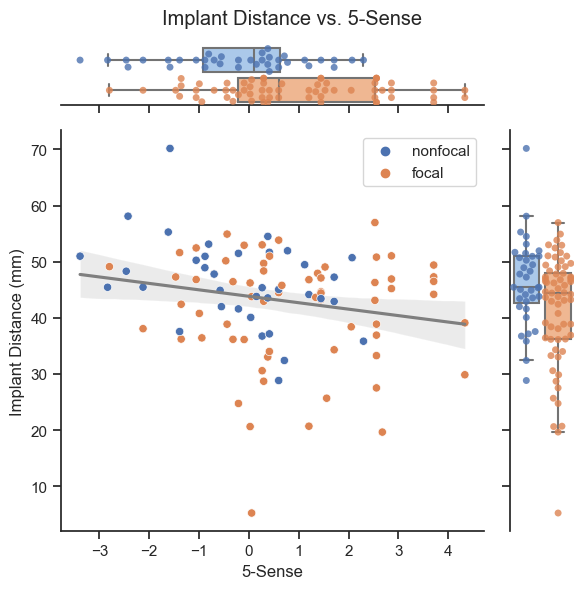

In [63]:
g = PlotDecision(All_X.reset_index("focality"), "fivesense", "Unweighted", "focality")
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.92)
g.figure.suptitle("Implant Distance vs. 5-Sense")
h, l = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(h, ["nonfocal", "focal"], title="")
g.ax_joint.set_xlabel("5-Sense")
g.ax_joint.set_ylabel("Implant Distance (mm)")
g.savefig(ospj(figpath, "implant_5sense.pdf"))

/tmp/ipykernel_43284/904667853.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/tmp/ipykernel_43284/904667853.py:34: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 9.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


PearsonRResult(statistic=-0.13241983942601676, pvalue=0.1868151678612114)


/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarnin

<Figure size 640x480 with 0 Axes>

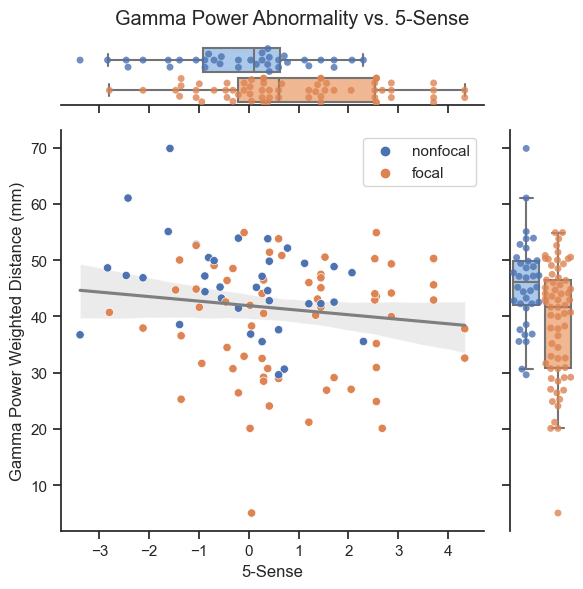

In [64]:
g = PlotDecision(All_X.reset_index("focality"), "fivesense", "gamma_bp", "focality")
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.92)
g.figure.suptitle("Gamma Power Abnormality vs. 5-Sense")
h, l = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(h, ["nonfocal", "focal"], title="")
g.ax_joint.set_xlabel("5-Sense")
g.ax_joint.set_ylabel("Gamma Power Weighted Distance (mm)")
g.savefig(ospj(figpath, "gamma_5sense.pdf"))

In [65]:
X = All_X.dropna().reset_index(
    "focality"
)  # .drop('fivesense',axis=1).join(FiveSensePreds.droplevel('focality'))
y = X.pop("focality")

,cohend,u-stat,ranksum,roc,ci
variable,,,,,
fivesense,-0.716652,759.0,0.003595,0.675641,"(0.5700507952493915, 0.7812312052922955)"
gamma_bp,0.690479,1571.0,0.004514,0.671368,"(0.5654248929585997, 0.7773102783594545)"
broad_bp,0.657506,1551.0,0.006976,0.662821,"(0.5544052664692471, 0.7712357695643832)"
delta_bp,0.579081,1534.0,0.009954,0.655556,"(0.5460759146787283, 0.7650351778887156)"
theta_bp,0.577375,1507.0,0.017033,0.644017,"(0.533804605666937, 0.7542297142106875)"
delta_coh,0.537370,1482.0,0.027194,0.633333,"(0.521505228270434, 0.7451615417109503)"
alpha_bp,0.558132,1474.0,0.031398,0.629915,"(0.5195826717851176, 0.7402462533476338)"
alpha_coh,0.538932,1474.0,0.031398,0.629915,"(0.5170417195862275, 0.742787205546524)"
Unweighted,0.517780,1447.0,0.049932,0.618376,"(0.5054235320626004, 0.7313286203803318)"


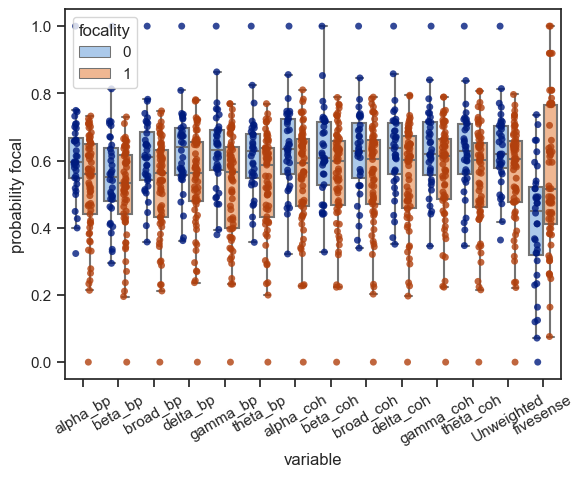

In [66]:
res, ax = PrettyPictures(X, y, scale=True)
# res['cohend'].abs()

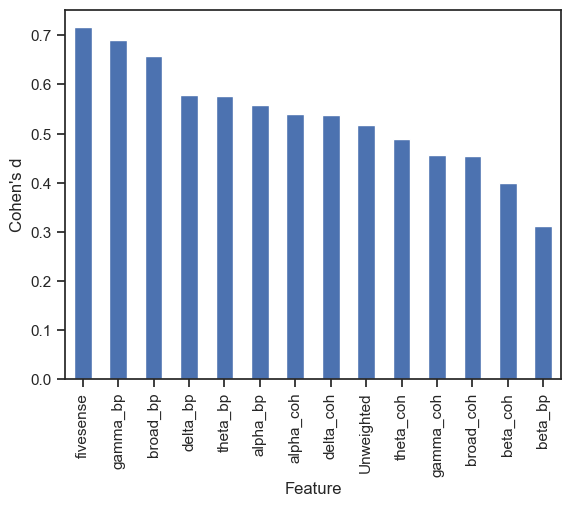

In [67]:
res.xs("cohend", level="metric").rename(columns={"focality": "Cohen's d"})[
    "Cohen's d"
].abs().sort_values(ascending=False).plot.bar()
plt.ylabel("Cohen's d")
plt.xlabel("Feature")
plt.savefig(ospj(figpath, "cohend.pdf"), bbox_inches="tight")

In [68]:
order = [
    "fivesense",
    "gamma_bp",
    "broad_bp",
    "delta_bp",
    "theta_bp",
    "alpha_bp",
    "beta_bp",
    "delta_coh",
    "alpha_coh",
    "theta_coh",
    "broad_coh",
    "gamma_coh",
    "beta_coh",
    "Unweighted",
]

In [69]:
bardata = res.xs("roc", level="metric").rename(columns={"focality": "AUC"})
xpos = [1] + list(np.arange(6) + 3) + list(np.arange(6) + 10) + [17]
error = (
    res.xs("ci", level="metric")["focality"]
    .apply(pd.Series)
    .sub(res.xs("roc", level="metric")["focality"], axis=0)
    .max(axis=1)
)

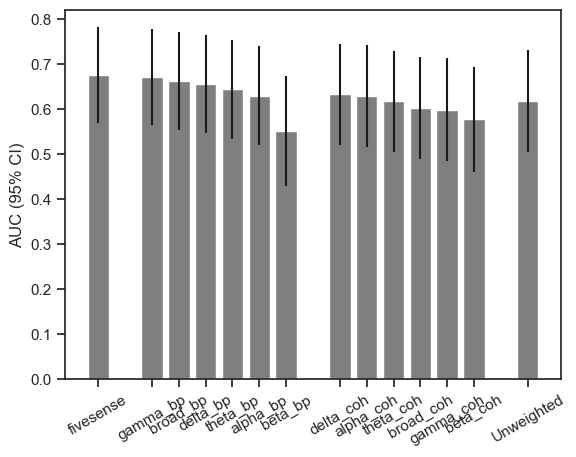

In [70]:
# create an errorbar plot of the auc and ci for each feature and use the order above
plt.figure()
plt.bar(
    x=xpos,
    height=res.xs("roc", level="metric").loc[order].values.flatten(),
    yerr=res.xs("ci", level="metric")["focality"]
    .apply(pd.Series)
    .sub(res.xs("roc", level="metric")["focality"], axis=0)
    .loc[order]
    .max(axis=1)
    .values.flatten(),
    tick_label=order,
    color="tab:gray",
)
plt.xticks(rotation=30)
plt.ylabel("AUC (95% CI)")
plt.savefig(ospj(figpath, "univar_auc.pdf"), bbox_inches="tight")

,cohend,u-stat,ranksum,roc,ci
variable,,,,,
fivesense,-0.716652,759.0,0.003595,0.675641,"(0.5700507952493915, 0.7812312052922955)"
gamma_bp,0.690479,1571.0,0.004514,0.671368,"(0.5654248929585997, 0.7773102783594545)"
delta_coh,0.537370,1482.0,0.027194,0.633333,"(0.521505228270434, 0.7451615417109503)"
Unweighted,0.517780,1447.0,0.049932,0.618376,"(0.5054235320626004, 0.7313286203803318)"


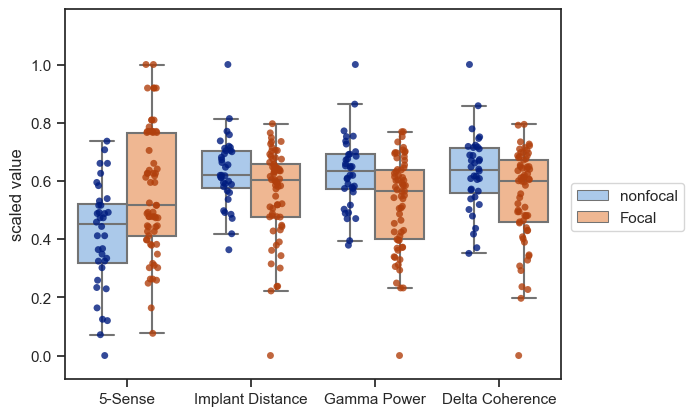

In [71]:
res, ax = PrettyPictures(
    X[["fivesense", "Unweighted", "gamma_bp", "delta_coh"]], y, scale=True
)
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["nonfocal", "Focal"], title=None, loc=(1.02, 0.4))
ax.set_xticklabels(["5-Sense", "Implant Distance", "Gamma Power", "Delta Coherence"])
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("scaled value")
plt.ylim((-0.08, 1.19))
plt.savefig(ospj(figpath, "univariate.pdf"), bbox_inches="tight")

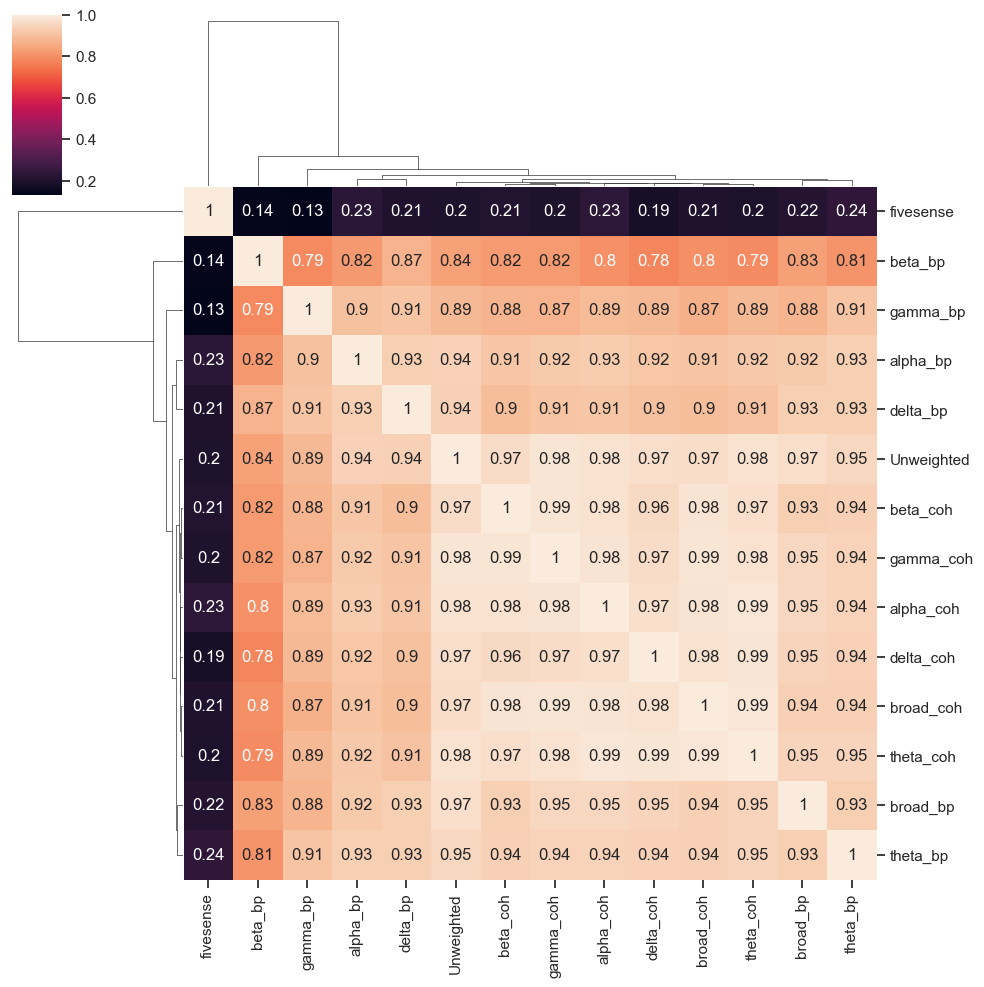

In [72]:
g = sns.clustermap(
    pd.DataFrame(
        preprocessing.StandardScaler().fit_transform(X),
        index=X.index,
        columns=X.columns,
    )
    .corr()
    .abs(),
    annot=True,
    figsize=(10, 10),
)
g.savefig(ospj(figpath, "clustermap.pdf"), bbox_inches="tight")

plt.savefig(ospj(figpath, "clustermap.pdf"))

In [73]:
X_subsets = {
    "Preimplant Baseline": All_X[["fivesense", "Unweighted"]],
    "IEEG Model": All_X,  # for supplement: remove comment this line
}

In [74]:
models = {}
for k, X in X_subsets.items():
    X = X.reset_index("focality")
    y_all = X.pop("focality")
    print(k, X.shape)
    in_sample = MakePredictions(X, y, k)
    print(metrics.roc_auc_score(y, in_sample))

    models[k] = ML_Model(X, y_all)
pd.concat(
    [pd.Series(mod[0]) for mod in models.values()], keys=[key for key in models.keys()]
)

Preimplant Baseline (101, 2)
Optimization terminated successfully.
         Current function value: 0.575880
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               focality   No. Observations:                  101
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Apr 2024   Pseudo R-squ.:                  0.1159
Time:                        18:24:04   Log-Likelihood:                -58.164
converged:                       True   LL-Null:                       -65.785
Covariance Type:            nonrobust   LLR p-value:                 0.0004898
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6961      0.231      3.014      0.003       0.243       1.149


Preimplant Baseline  roc_score    0.674359
                     bac          0.568162
IEEG Model           roc_score    0.790598
                     bac          0.694658
dtype: float64

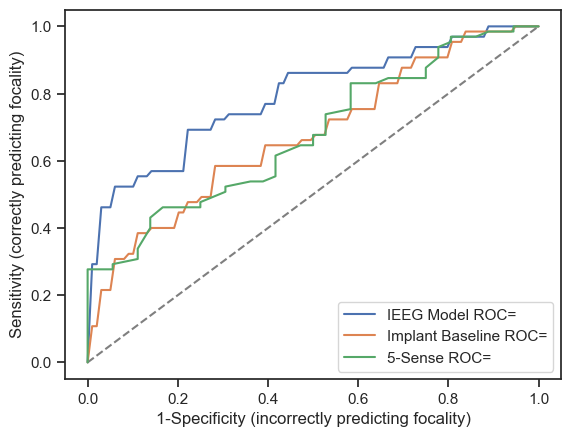

In [75]:
all_tprs = []
for k, v in models.items():
    all_tprs.append(v[1])
roc_curves = (
    pd.concat(all_tprs, keys=models.keys(), names=["model", "fpr"])
    .melt(ignore_index=False, var_name="fold", value_name="tpr")
    .reset_index()
)
fig, ax = plt.subplots()
sns.lineplot(
    data=roc_curves,
    x="fpr",
    y="tpr",
    hue="model",
    ax=ax,
    hue_order=["IEEG Model", "Preimplant Baseline"],
)
plt.plot([0, 1], [0, 1], color="tab:gray", linestyle="--")
plt.ylabel("Sensitivity (correctly predicting focality)")
plt.xlabel("1-Specificity (incorrectly predicting focality)")
fpr, tpr, thresh = metrics.roc_curve(y_all.values, All_X["fivesense"].values)
plt.plot(fpr, tpr, label="5-Sense")
h, l = ax.get_legend_handles_labels()
plt.legend(
    h, ["IEEG Model ROC=", "Implant Baseline ROC=", "5-Sense ROC="], loc="lower right"
)
plt.savefig(ospj(figpath, "roc_curve.pdf"), bbox_inches="tight")

In [76]:
roc_curves["distance"] = np.sqrt(roc_curves["fpr"] ** 2 + (1 - roc_curves["tpr"]) ** 2)

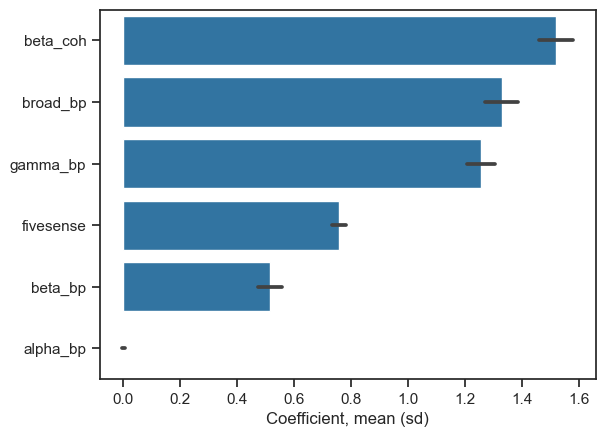

In [77]:
coefs = models["IEEG Model"][3]
coefs = coefs.loc[:, ~(coefs == 0).all()].abs()
order = coefs.mean().sort_values(ascending=False).index.tolist()
sns.barplot(coefs, order=order, orient="h", errorbar="sd", color="tab:blue")
plt.xlabel("Coefficient, mean (sd)")
plt.savefig(ospj(figpath, "coefs1.pdf"), bbox_inches="tight")

In [78]:
PredClass = []
for k, mod in models.items():
    PredClass.append(
        mod[2]["true"]
        .to_frame()
        .join(
            pd.Series(mod[2]["yhat"], index=mod[2]["true"].index).rename(
                f"{k} Prediction"
            )
        )
        .set_index("focality", append=True)
    )

In [79]:
models

{'Preimplant Baseline': ({'roc_score': 0.6743589743589743,
   'bac': 0.5681623931623931},
                   0
  0.000000  0.000000
  0.010101  0.107692
  0.020202  0.107692
  0.030303  0.215385
  0.040404  0.215385
  ...            ...
  0.959596  1.000000
  0.969697  1.000000
  0.979798  1.000000
  0.989899  1.000000
  1.000000  1.000000
  
  [100 rows x 1 columns],
  {'true': patient
   HUP064    1
   HUP065    1
   HUP068    1
   HUP070    1
   HUP073    0
            ..
   HUP210    0
   HUP213    0
   HUP215    1
   HUP216    1
   HUP218    1
   Name: focality, Length: 101, dtype: int64,
   'pred': array([0.85908755, 0.63933135, 0.53484006, 0.72657818, 0.50835453,
          0.42889715, 0.53340409, 0.42009077, 0.83901812, 0.47959372,
          0.7355889 , 0.90281927, 0.25605365, 0.60241094, 0.67303505,
          0.82720173, 0.55723025, 0.36544218, 0.54217351, 0.57711553,
          0.80151132, 0.5575306 , 0.22720432, 0.78898852, 0.63055744,
          0.68675907, 0.53759664, 0.44142

In [80]:
PredClass = (
    pd.concat(PredClass, axis=1)
    .groupby(["patient", "focality"])
    .mean()
    .join((FiveSensePreds > 0.376).astype(int), how="inner")
    .reset_index("focality")
)

In [81]:
yhat = FiveSensePreds.loc[All_Patient] > 0.376
print(metrics.classification_report(yhat.index.get_level_values("focality"), yhat))

              precision    recall  f1-score   support

           0       0.58      0.42      0.48        36
           1       0.72      0.83      0.77        65

    accuracy                           0.68       101
   macro avg       0.65      0.62      0.63       101
weighted avg       0.67      0.68      0.67       101



In [82]:
print(
    metrics.classification_report(
        PredClass["focality"], PredClass["IEEG Model Prediction"]
    )
)

              precision    recall  f1-score   support

           0       0.68      0.53      0.59        36
           1       0.77      0.86      0.81        65

    accuracy                           0.74       101
   macro avg       0.72      0.69      0.70       101
weighted avg       0.74      0.74      0.73       101



In [83]:
pd.crosstab(PredClass["focality"], PredClass["IEEG Model Prediction"])

IEEG Model Prediction,0.0,1.0
focality,,
0,19,17
1,9,56


In [84]:
pd.crosstab(PredClass["focality"], PredClass["fivesense"])

fivesense,0,1
focality,,
0,15,21
1,11,54


In [85]:
# return true where other columns of predclass are equal to predclass['focality']
PredClass["IEEG Model Prediction"] = (
    PredClass["IEEG Model Prediction"] == PredClass["focality"]
).map({True: "correct", False: "incorrect"})
PredClass["fivesense"] = (PredClass["fivesense"] == PredClass["focality"]).map(
    {True: "correct", False: "incorrect"}
)

In [86]:
pd.crosstab(PredClass["fivesense"], PredClass["IEEG Model Prediction"])

IEEG Model Prediction,correct,incorrect
fivesense,,
correct,66,3
incorrect,9,23


In [87]:
PredClass.query(
    'fivesense == "incorrect" and `IEEG Model Prediction` == "correct"'
).join(PreImplantData["RID"])

,focality,Preimplant Baseline Prediction,IEEG Model Prediction,fivesense,RID
patient,,,,,
HUP073,0,1.0,correct,incorrect,63
HUP145,1,1.0,correct,incorrect,167
HUP148,0,1.0,correct,incorrect,267
HUP161,1,1.0,correct,incorrect,338
HUP169,0,1.0,correct,incorrect,296
HUP186,0,1.0,correct,incorrect,420
HUP203,0,1.0,correct,incorrect,560
HUP205,0,1.0,correct,incorrect,588
HUP218,1,0.0,correct,incorrect,677


In [88]:
PredClass.query(
    'fivesense == "correct" and `IEEG Model Prediction` == "incorrect"'
).join(PreImplantData["RID"])

,focality,Preimplant Baseline Prediction,IEEG Model Prediction,fivesense,RID
patient,,,,,
HUP127,0,0.0,incorrect,correct,186
HUP149,0,0.0,incorrect,correct,240
HUP216,1,1.0,incorrect,correct,658


In [89]:
from tools import delong

assert (
    models["Preimplant Baseline"][2]["true"] == models["IEEG Model"][2]["true"]
).all()
AvgPreds = []
for k, mod in models.items():
    AvgPreds.append(
        mod[2]["true"]
        .to_frame()
        .join(
            pd.Series(mod[2]["pred"], index=mod[2]["true"].index).rename(
                f"{k} Prediction"
            )
        )
        .set_index("focality", append=True)
    )

In [90]:
AvgPreds = (
    pd.concat(AvgPreds, axis=1)
    .groupby(["patient", "focality"])
    .mean()
    .join(FiveSensePreds, how="inner")
    .reset_index("focality")
)

In [91]:
print(
    10
    ** delong.delong_roc_test(
        AvgPreds["focality"], AvgPreds["IEEG Model Prediction"], AvgPreds["fivesense"]
    )
)
print(
    10
    ** delong.delong_roc_test(
        AvgPreds["focality"],
        AvgPreds["IEEG Model Prediction"],
        AvgPreds["Preimplant Baseline Prediction"],
    )
)
print(
    10
    ** delong.delong_roc_test(
        AvgPreds["focality"],
        AvgPreds["fivesense"],
        AvgPreds["Preimplant Baseline Prediction"],
    )
)

[[0.01344517]]
[[0.00296418]]
[[0.96379215]]


In [92]:
sm.stats.multipletests(
    [
        10
        ** delong.delong_roc_test(
            AvgPreds["focality"],
            AvgPreds["IEEG Model Prediction"],
            AvgPreds["fivesense"],
        )[0][0],
        10
        ** delong.delong_roc_test(
            AvgPreds["focality"],
            AvgPreds["IEEG Model Prediction"],
            AvgPreds["Preimplant Baseline Prediction"],
        )[0][0],
        10
        ** delong.delong_roc_test(
            AvgPreds["focality"],
            AvgPreds["fivesense"],
            AvgPreds["Preimplant Baseline Prediction"],
        )[0][0],
    ],
    method="holm",
)

(array([ True,  True, False]),
 array([0.02689034, 0.00889255, 0.96379215]),
 0.016952427508441503,
 0.016666666666666666)

In [93]:
fpr, tpr, thresh = metrics.roc_curve(
    AvgPreds["focality"], AvgPreds["IEEG Model Prediction"]
)

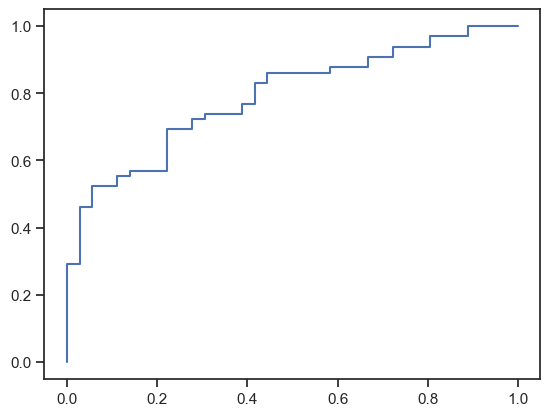

In [94]:
roc_curves = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresh": thresh})
roc_curves["distance"] = np.sqrt(roc_curves["fpr"] ** 2 + (1 - roc_curves["tpr"]) ** 2)
plt.plot(roc_curves["fpr"], roc_curves["tpr"], label="IEEG Model")

In [95]:
X = AvgPreds.copy()
y = X.pop("focality")

,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-1.125532,490.0,0.000001,0.790598,"(0.7036240286101894, 0.8775726371536656)"
fivesense,-0.638013,759.0,0.003595,0.675641,"(0.5700507952493915, 0.7812312052922955)"
Preimplant Baseline Prediction,-0.655876,762.0,0.003860,0.674359,"(0.5676711705384648, 0.781046876603564)"


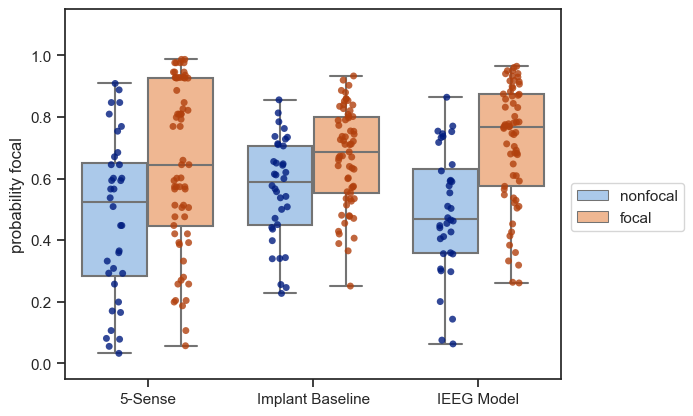

In [96]:
metric_scores, ax = PrettyPictures(
    X[["fivesense", "Preimplant Baseline Prediction", "IEEG Model Prediction"]], y
)
ax.set_xlabel("")
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["nonfocal", "focal"], loc=(1.02, 0.4))
ax.set_xticklabels(["5-Sense", "Implant Baseline", "IEEG Model"])
ax.set_ylim(-0.05, 1.15)
plt.xticks(
    rotation=0,
)
plt.savefig(ospj(figpath, "ieegmodel.pdf"), bbox_inches="tight")

/tmp/ipykernel_43284/2415615201.py:35: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_43284/2415615201.py:47: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, User

<Figure size 640x480 with 0 Axes>

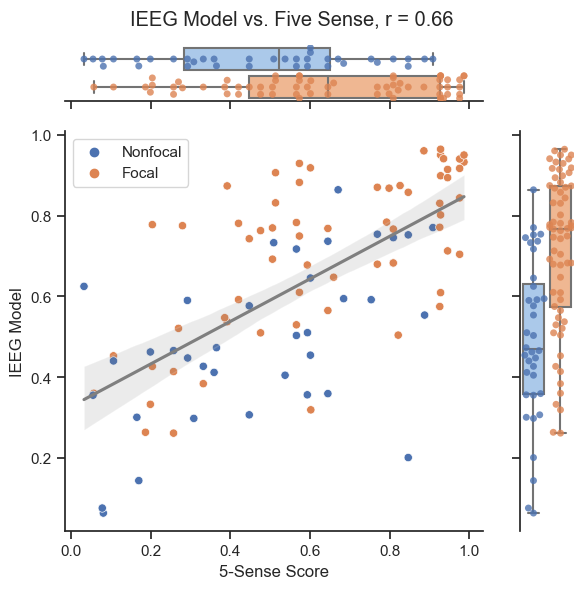

<Figure size 640x480 with 0 Axes>

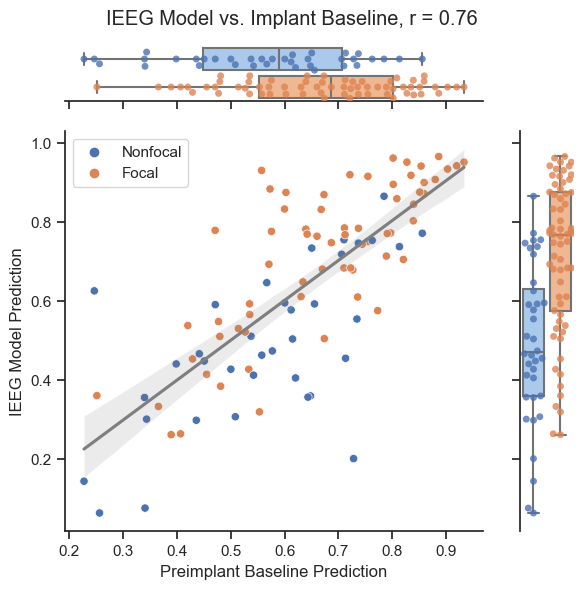

In [97]:
with sns.axes_style("ticks"):
    f, g = PlotLogit(X, y)
    h, l = f.ax_joint.get_legend_handles_labels()
    f.ax_joint.legend(handles=h, labels=["Nonfocal", "Focal"], loc="best")
    f.figure.savefig(ospj(figpath, "fivesense_corr.pdf"), bbox_inches="tight")
    # f.ax_joint.spines[:].set_visible(True)
    h, l = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=h, labels=["Nonfocal", "Focal"], loc="best")
    g.figure.savefig(ospj(figpath, "null_corr.pdf"), bbox_inches="tight")

In [98]:
# data = pd.DataFrame({'logit proba':preds,
#                   'unweighted':preds_unweighted,
#                     'focality':y
#                  })
# g = sns.lmplot(data, x = 'unweighted', y = 'logit proba', hue = 'focality', fit_reg= False)
# sns.regplot(data, x = 'unweighted', y = 'logit proba', scatter=False, ax=g.axes[0, 0])
# plt.ylabel('logit proba')
# plt.text(0, 0.45, 'r = {:0.2f}'.format(np.corrcoef(preds, preds_unweighted)[0,1]))

### Analyze outcomes

procedure_type
1    61
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-1.079078,271.0,0.000497,0.766178,"(0.6378083100068666, 0.8945469985258483)"
Preimplant Baseline Prediction,-1.038579,275.0,0.000588,0.762726,"(0.6419107367330487, 0.883542353934676)"
fivesense,-0.794513,336.0,0.005989,0.710095,"(0.5755925353838877, 0.8445973220990225)"


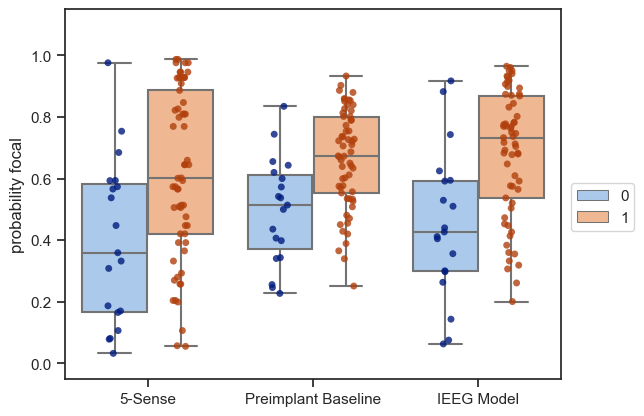

In [99]:
exog = X.join(
    type_of_proc[type_of_proc.isin(["surgery", "device"])].rename("procedure_type"),
    how="inner",
)
endog = exog.pop("procedure_type").map({"surgery": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(
    exog[["fivesense", "Preimplant Baseline Prediction", "IEEG Model Prediction"]],
    endog,
)
metric_scores = metric_scores.join(score)
ax.set_xlabel("")
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title="", loc=(1.02, 0.4))
ax.set_xticklabels(["5-Sense", "Preimplant Baseline", "IEEG Model"])
ax.set_ylim(-0.05, 1.15)
plt.xticks(rotation=0)
plt.savefig(ospj(figpath, "outcomes_surgery.pdf"), bbox_inches="tight")
# PlotLogit(exog,endog)

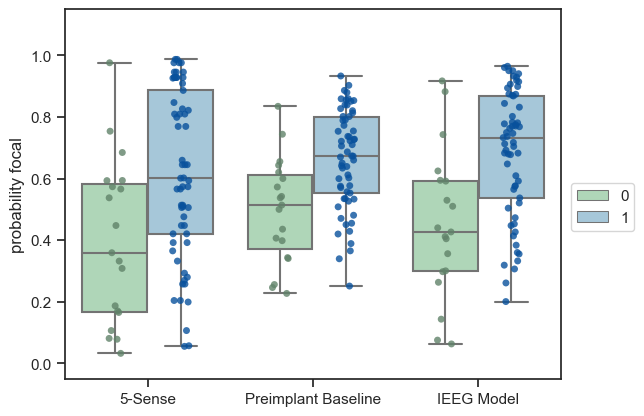

In [100]:
PlotSurgData = (
    exog[["fivesense", "Preimplant Baseline Prediction", "IEEG Model Prediction"]]
    .melt(ignore_index=False, var_name="variable")
    .join(endog, how="inner")
)
plt.figure()
ax = sns.boxplot(
    data=PlotSurgData,
    x="variable",
    y="value",
    hue="procedure_type",
    palette=sns.color_palette(["#a8ddb5", "#9ecae1"]),
    showfliers=False,
)
sns.stripplot(
    data=PlotSurgData,
    x="variable",
    y="value",
    hue="procedure_type",
    palette=sns.color_palette(["#608269", "#08519c"]),
    alpha=0.8,
    dodge=True,
    legend=False,
    ax=ax,
)

ax.set_xlabel("")
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title="", loc=(1.02, 0.4))
ax.set_xticklabels(["5-Sense", "Preimplant Baseline", "IEEG Model"])
ax.set_ylim(-0.05, 1.15)
plt.xticks(rotation=0)
plt.ylabel("probability focal")
plt.savefig(ospj(figpath, "outcomes_surgery.pdf"), bbox_inches="tight")

In [101]:
outcomes

,Record ID,HUP Number,IEEG Portal Number,Gender,Age of Epilepsy onset (in years),Age at implant,Type of Implant:,Type of Surgery:,1 year,2 years,1 year.1,2 years.1,Hemisphere of Resection,Type of resection,Area of resection,Lateralization of Ablation,Region of ablation,Specific region of ablation,Region of ablation.1,Specific region of ablation.1
name,,,,,,,,,,,,,,,,,,,,
HUP082,13,82,I002_P019; HUP82_phaseII,Female (2),29.0,56.0,"Grids,Strips,Depths (not Stereo EEG)",Resection with intracranial implant,ILAE 3,ILAE 1,Engel class IB,Engel class IA,Right,"Neocortical,Selective amygdalohippocampectomy",More extensive right temporal lobectomy that e...,NaN,NaN,NaN,NaN,NaN
HUP083,14,83,I002_P020; HUP83_phaseII,Male (1),8.0,39.0,"Grids,Strips,Depths (not Stereo EEG)",Resection with intracranial implant,ILAE 1a,ILAE 1a,Engel class IA,Engel class IA,Left,Neocortical,left somatosensory cortex,NaN,NaN,NaN,NaN,NaN
HUP084,15,84,I002_P021; HUP84_phaseII,Male (1),0.9,53.0,"Strips,Depths (not Stereo EEG)",RNS,ILAE 5,ILAE 5,Engel class IIIA,Engel class IIIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HUP085,16,85,I002_P022,Male (1),44.0,45.0,"Grids,Strips",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HUP086,18,86,I002_P023; HUP86_phaseII,Female (2),18.0,25.0,"Grids,Strips,Depths (not Stereo EEG)",Resection with intracranial implant,ILAE 3,ILAE 1,Engel class IIA,Engel class IIA,Left,"Neocortical,Selective amygdalohippocampectomy",left lateral temporal lobectomy and amygdalohi...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUP237,885,237,HUP237_phaseII,Female (2),NaN,54.0,"Stereo EEG (Depths ONLY, do not check Depths)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HUP241,890,241,HUP241_phaseII,Male (1),NaN,40.0,Grids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HUP246,893,246,NaN,Male (1),NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
ILAE = (
    outcomes.loc[((type_of_proc == "surgery"))][
        [
            "1 year",
            "2 years",
        ]
    ]
    .replace("ILAE 1a", "ILAE 1")
    .astype("category")
)
ILAE = (
    ILAE.applymap(lambda x: int(str(x).strip()[-1]) if x is not np.nan else np.nan)
    .mask(lambda x: x.isin([1, 2]), 1)
    .where(lambda x: x.isin([1, np.nan]), 0)
)
engel = outcomes.loc[((type_of_proc == "surgery"))][
    [
        "1 year.1",
        "2 years.1",
    ]
]
assert (
    not (
        engel.applymap(lambda x: str(x).strip()[-1] if x is not np.nan else np.nan)
        == "I"
    )
    .any()
    .any()
)
engel = engel.applymap(
    lambda x: str(x).strip()[:-1].split(" ")[-1] if x is not np.nan else np.nan
)
engel = engel.replace(["I", "II", "III", "IV"], [1, 2, 3, 4]).where(
    lambda x: x.isin([1, np.nan]), 0
)
Surg_Outcomes = engel.join(ILAE)

In [103]:
Surg_Outcomes

,1 year.1,2 years.1,1 year,2 years
name,,,,
HUP082,1.0,1.0,0.0,1.0
HUP083,1.0,1.0,1.0,1.0
HUP086,0.0,0.0,0.0,1.0
HUP087,1.0,1.0,1.0,0.0
HUP088,1.0,1.0,0.0,1.0
...,...,...,...,...
HUP225,NaN,NaN,NaN,NaN
HUP223,NaN,NaN,NaN,NaN
HUP235,NaN,NaN,NaN,NaN


In [104]:
# outcome_classes = np.unique(outcomes[((type_of_proc=='surgery'))][["1 year", "1 year.1", "2 years", "2 years.1"]].dropna().values.ravel().astype(str))
# Surg_Outcomes = (
#     outcomes[( (type_of_proc == "surgery"))][
#         ["1 year", "1 year.1", "2 years", "2 years.1"]
#     ]
#     .mask(
#         lambda x: x.isin(
#             [
#                 "Engel class IA",
#                 "Engel class IB",
#                 "Engel class IC",
#                 "Engel class ID",
#                 "ILAE 1",
#                 "ILAE 1a",
#                 # "ILAE 2",
#             ]
#         ),
#         1,
#     )
#     .mask(lambda x: x.isin(outcome_classes), 0)
# )
# Surg_Outcomes.value_counts(dropna=False)

In [105]:
GoodOutcome1 = (
    (Surg_Outcomes["1 year.1"].dropna() == 1)
    # |
    # (Surg_Outcomes["1 year"].dropna() == 1)
).rename("good_outcome_1yr")

good_outcome_1yr
1    36
0    18
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-0.563056,222.0,0.062538,0.657407,"(0.5029389667845843, 0.8118758391999128)"
fivesense,-0.072896,312.0,0.832735,0.518519,"(0.3430856601312608, 0.6939514740392714)"
Preimplant Baseline Prediction,-0.084368,317.0,0.905061,0.510802,"(0.338957865823335, 0.6826471489776904)"


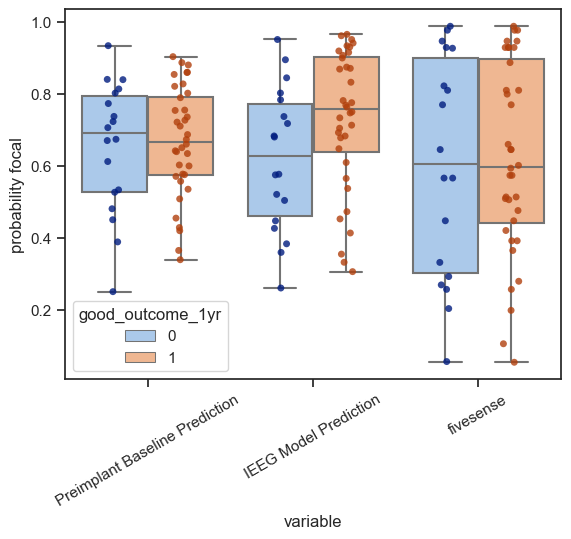

In [106]:
exog = X.join(GoodOutcome1).dropna().copy()
endog = exog.pop("good_outcome_1yr").astype(int)
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# PlotLogit(exog,endog)

relapse_1_device
0    19
1    18
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
Preimplant Baseline Prediction,-0.895145,89.0,0.013267,0.739766,"(0.574422411428646, 0.905109830392643)"
IEEG Model Prediction,-0.756752,104.0,0.043308,0.695906,"(0.5223468844776364, 0.8694659168834475)"
fivesense,-0.704384,107.5,0.055471,0.685673,"(0.5088939007253401, 0.8624511424570329)"


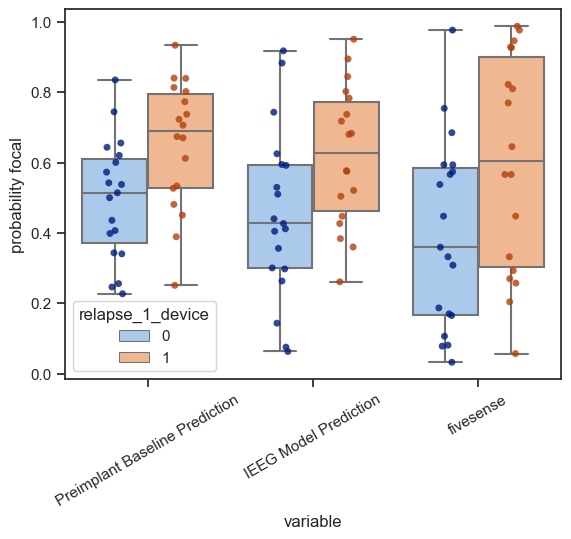

In [107]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome1[~GoodOutcome1].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["relapse", "device"],
    names=["relapse_1_device"],
).reset_index("relapse_1_device")
endog = exog.pop("relapse_1_device").map({"relapse": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'relapse':1, 'device':0}))
# PlotLogit(exog, endog)

szfree_1_device
1    36
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-1.317222,125.0,0.000127,0.817251,"(0.6932917734416785, 0.9412113527027307)"
Preimplant Baseline Prediction,-1.074641,156.0,0.001026,0.771930,"(0.6406155261624241, 0.9032441940676784)"
fivesense,-0.835946,193.5,0.008772,0.717105,"(0.5713471058741523, 0.8628634329899835)"


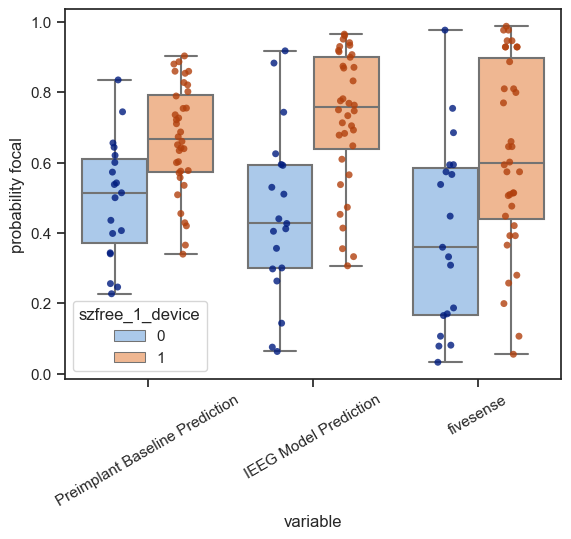

In [108]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome1[GoodOutcome1].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["surg_good", "device"],
    names=["szfree_1_device"],
).reset_index("szfree_1_device")
endog = exog.pop("szfree_1_device").map({"surg_good": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'surg_good':1, 'device':0}))
# PlotLogit(exog, endog)

In [109]:
GoodOutcome1 = (
    # (Surg_Outcomes["1 year.1"].dropna() == 1)
    # |
    (Surg_Outcomes["1 year"].dropna() == 1)
).rename("good_outcome_1yr_ilae")

good_outcome_1yr_ilae
1    30
0    23
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-0.484430,254.0,0.104350,0.631884,"(0.47853991641723703, 0.7852281604794304)"
Preimplant Baseline Prediction,0.015327,357.0,0.836494,0.517391,"(0.35538850763102814, 0.6793940212462302)"
fivesense,0.080327,350.5,0.928438,0.507971,"(0.3473959849444148, 0.6685459925565007)"


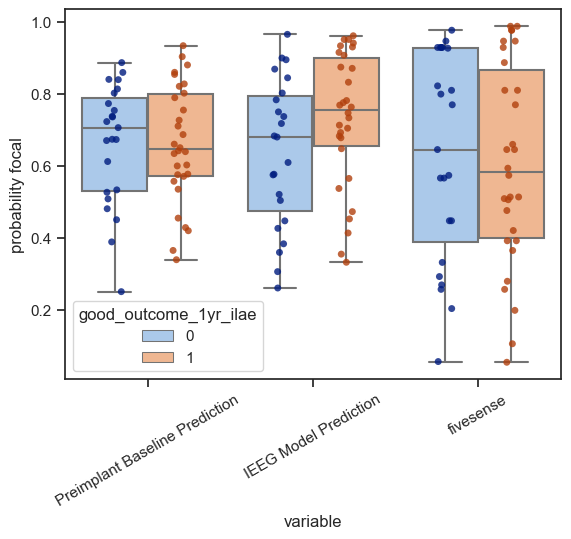

In [110]:
exog = X.join(GoodOutcome1).dropna().copy()
endog = exog.pop("good_outcome_1yr_ilae").astype(int)
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# PlotLogit(exog,endog)

relapse_1_device_ilae
1    23
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
Preimplant Baseline Prediction,-0.989902,104.0,0.003966,0.762014,"(0.6140587295916973, 0.909968617973)"
fivesense,-0.821999,125.5,0.019308,0.712815,"(0.5527281464928969, 0.8729012308722154)"
IEEG Model Prediction,-0.822727,126.0,0.020078,0.711670,"(0.5495458631973931, 0.8737951726455024)"


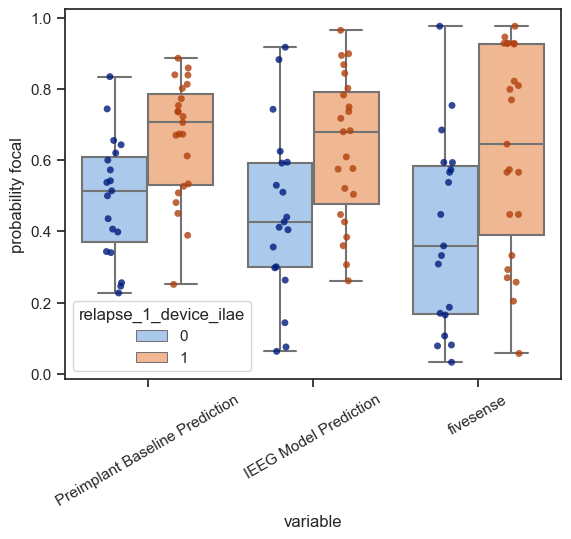

In [111]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome1[~GoodOutcome1].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["relapse", "device"],
    names=["relapse_1_device_ilae"],
).reset_index("relapse_1_device_ilae")
endog = exog.pop("relapse_1_device_ilae").map({"relapse": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'relapse':1, 'device':0}))
# PlotLogit(exog, endog)

szfree_1_device_ilae
1    30
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-1.324082,103.0,0.000196,0.819298,"(0.6920020510847036, 0.9465944836443003)"
Preimplant Baseline Prediction,-0.992724,139.0,0.002830,0.756140,"(0.6165649380673721, 0.8957157645235703)"
fivesense,-0.751428,172.5,0.021508,0.697368,"(0.5444213901127756, 0.85031537670241)"


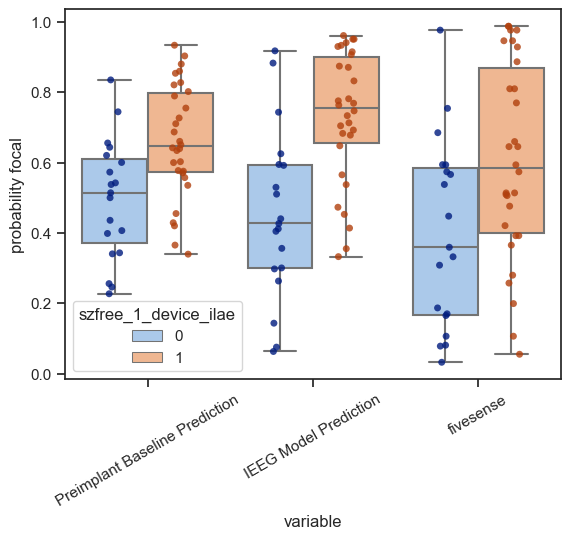

In [112]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome1[GoodOutcome1].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["surg_good", "device"],
    names=["szfree_1_device_ilae"],
).reset_index("szfree_1_device_ilae")
endog = exog.pop("szfree_1_device_ilae").map({"surg_good": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'surg_good':1, 'device':0}))
# PlotLogit(exog, endog)

In [113]:
GoodOutcome2 = (
    (Surg_Outcomes["2 years.1"].dropna() == 1)
    # &
    # (Surg_Outcomes["2 years"].dropna() == 1)
    # & (GoodOutcome1)
).rename("good_outcome_2yr")

good_outcome_2yr
1    36
0    16
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-0.759982,157.0,0.009672,0.727431,"(0.5839321009385543, 0.8709290631544633)"
Preimplant Baseline Prediction,-0.387917,232.0,0.271176,0.597222,"(0.4201863160788714, 0.7742581018746197)"
fivesense,-0.239873,248.0,0.433143,0.569444,"(0.38562818970017776, 0.7532606462068047)"


(array([0, 1, 2]),
 [Text(0, 0, '5-Sense'),
  Text(1, 0, 'Preimplant Baseline'),
  Text(2, 0, 'IEEG Model')])

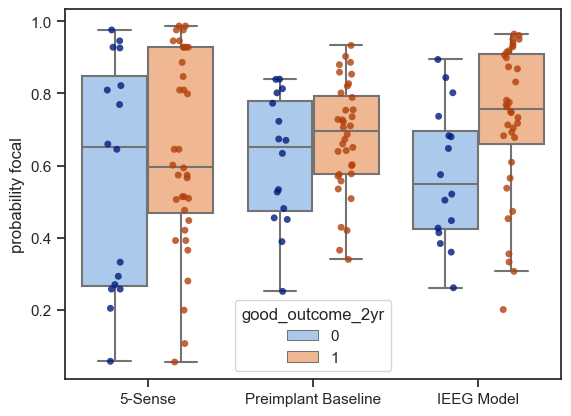

In [114]:
exog = X.join(GoodOutcome2, how="inner").dropna().copy()
endog = exog.pop("good_outcome_2yr").astype(int)
print(endog.value_counts())
score, ax = PrettyPictures(
    exog[["fivesense", "Preimplant Baseline Prediction", "IEEG Model Prediction"]],
    endog,
)
metric_scores = metric_scores.join(score)
ax.set_xlabel("")
h, l = ax.get_legend_handles_labels()
ax.set_xticklabels(["5-Sense", "Preimplant Baseline", "IEEG Model"])
plt.xticks(rotation=0)
# PlotLogit(exog,endog)

relapse_2_device
0    19
1    16
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
Preimplant Baseline Prediction,-0.687724,95.0,0.061359,0.687500,"(0.5046560725160858, 0.8703439274839142)"
fivesense,-0.596174,101.0,0.094411,0.667763,"(0.47587102800542763, 0.8596554383642012)"
IEEG Model Prediction,-0.558486,106.0,0.131899,0.651316,"(0.4651922885274904, 0.8374393280649168)"


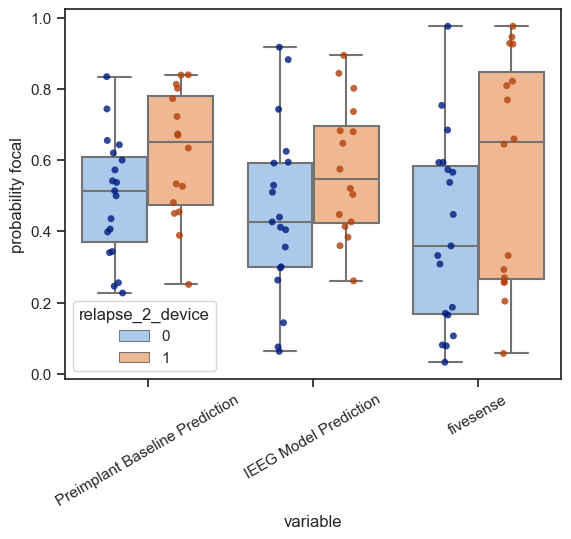

In [115]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome2[~GoodOutcome2].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["relapse", "device"],
    names=["relapse_2_device"],
).reset_index("relapse_2_device")
endog = exog.pop("relapse_2_device").map({"relapse": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'relapse':1, 'device':0}))
# PlotLogit(exog, endog)

szfree_2_device
1    36
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-1.256053,129.0,0.000169,0.811404,"(0.6880346601552615, 0.9347726041727414)"
Preimplant Baseline Prediction,-1.152724,145.0,0.000505,0.788012,"(0.6599322432191511, 0.9160910970060686)"
fivesense,-0.907880,185.0,0.005581,0.729532,"(0.5865733979099039, 0.8724908473140951)"


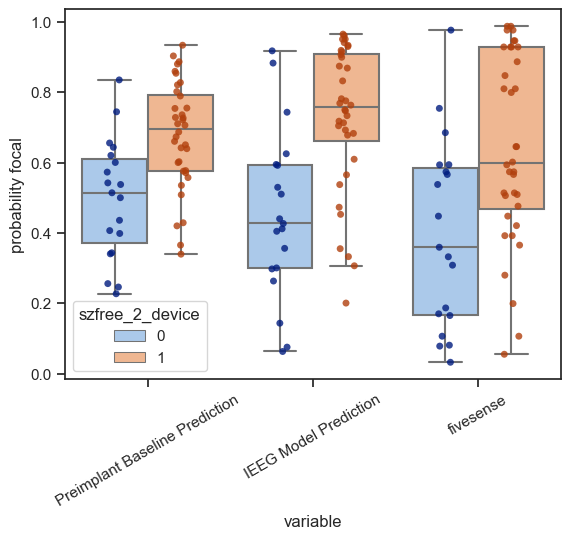

In [116]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome2[GoodOutcome2].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["surg_good", "device"],
    names=["szfree_2_device"],
).reset_index("szfree_2_device")
endog = exog.pop("szfree_2_device").map({"surg_good": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'surg_good':1, 'device':0}))
# PlotLogit(exog, endog)

In [117]:
GoodOutcome2 = (
    # (Surg_Outcomes["2 years.1"].dropna() == 1)
    # &
    (Surg_Outcomes["2 years"].dropna() == 1)
    # & (GoodOutcome1)
).rename("good_outcome_2yr_ilae")

good_outcome_2yr_ilae
1    33
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-0.693050,185.0,0.015001,0.704944,"(0.559668798561406, 0.8502195881649734)"
Preimplant Baseline Prediction,-0.721076,198.0,0.028865,0.684211,"(0.5236030526139014, 0.8448181443236596)"
fivesense,-0.661486,201.0,0.033156,0.679426,"(0.5163456397678018, 0.8425059122417807)"


(array([0, 1, 2]),
 [Text(0, 0, '5-Sense'),
  Text(1, 0, 'Preimplant Baseline'),
  Text(2, 0, 'IEEG Model')])

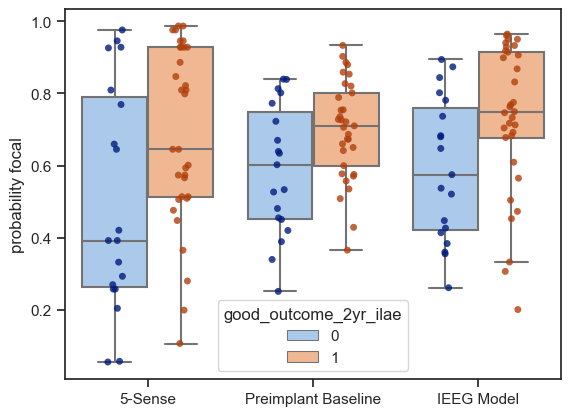

In [118]:
exog = X.join(GoodOutcome2, how="inner").dropna().copy()
endog = exog.pop("good_outcome_2yr_ilae").astype(int)
print(endog.value_counts())
score, ax = PrettyPictures(
    exog[["fivesense", "Preimplant Baseline Prediction", "IEEG Model Prediction"]],
    endog,
)
metric_scores = metric_scores.join(score)
ax.set_xlabel("")
h, l = ax.get_legend_handles_labels()
ax.set_xticklabels(["5-Sense", "Preimplant Baseline", "IEEG Model"])
plt.xticks(rotation=0)
# PlotLogit(exog,endog)

relapse_2_device_ilae
1    19
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-0.630792,121.0,0.084981,0.664820,"(0.48712271640884, 0.8425171952427714)"
Preimplant Baseline Prediction,-0.529606,130.0,0.144362,0.639889,"(0.46025789550045726, 0.8195203466107488)"
fivesense,-0.369922,145.0,0.306762,0.598338,"(0.41075978276113545, 0.7859162330927464)"


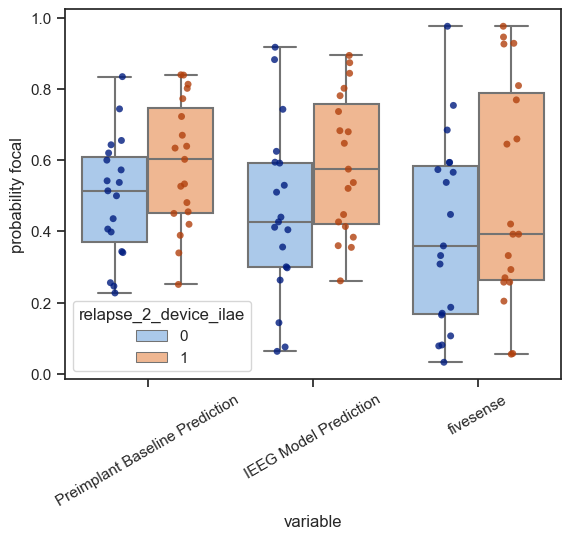

In [119]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome2[~GoodOutcome2].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["relapse", "device"],
    names=["relapse_2_device_ilae"],
).reset_index("relapse_2_device_ilae")
endog = exog.pop("relapse_2_device_ilae").map({"relapse": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'relapse':1, 'device':0}))
# PlotLogit(exog, endog)

szfree_2_device_ilae
1    33
0    19
Name: count, dtype: int64


,cohend,u-stat,ranksum,roc,ci
variable,,,,,
Preimplant Baseline Prediction,-1.359535,110.0,0.000115,0.824561,"(0.7033451451621331, 0.9457779274620735)"
IEEG Model Prediction,-1.276484,114.0,0.000156,0.818182,"(0.695559899340654, 0.9408039646043533)"
fivesense,-1.129204,141.0,0.001074,0.775120,"(0.6402613128082845, 0.9099778925521281)"


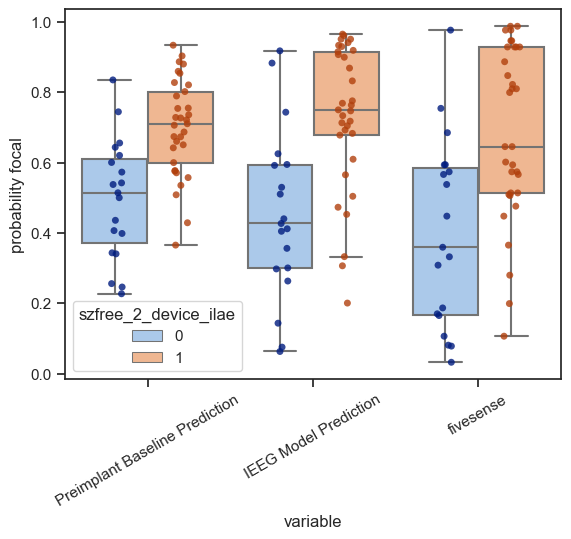

In [120]:
exog = pd.concat(
    [
        X[X.index.isin(GoodOutcome2[GoodOutcome2].index)],
        X[X.index.isin(type_of_proc[type_of_proc == "device"].index)],
    ],
    keys=["surg_good", "device"],
    names=["szfree_2_device_ilae"],
).reset_index("szfree_2_device_ilae")
endog = exog.pop("szfree_2_device_ilae").map({"surg_good": 1, "device": 0})
print(endog.value_counts())
score, ax = PrettyPictures(exog, endog)
metric_scores = metric_scores.join(score)
# MakePredictions(exog.drop('all_data',axis=1),endog.map({'surg_good':1, 'device':0}))
# PlotLogit(exog, endog)

In [121]:
GoodOutcome = pd.merge(
    GoodOutcome1, GoodOutcome2, how="outer", left_index=True, right_index=True
)

In [122]:
metric_scores

,,focality,procedure_type,good_outcome_1yr,relapse_1_device,szfree_1_device,good_outcome_1yr_ilae,relapse_1_device_ilae,szfree_1_device_ilae,good_outcome_2yr,relapse_2_device,szfree_2_device,good_outcome_2yr_ilae,relapse_2_device_ilae,szfree_2_device_ilae
variable,metric,,,,,,,,,,,,,,
IEEG Model Prediction,cohend,-1.125532,-1.079078,-0.563056,-0.756752,-1.317222,-0.48443,-0.822727,-1.324082,-0.759982,-0.558486,-1.256053,-0.69305,-0.630792,-1.276484
fivesense,cohend,-0.638013,-0.794513,-0.072896,-0.704384,-0.835946,0.080327,-0.821999,-0.751428,-0.239873,-0.596174,-0.90788,-0.661486,-0.369922,-1.129204
Preimplant Baseline Prediction,cohend,-0.655876,-1.038579,-0.084368,-0.895145,-1.074641,0.015327,-0.989902,-0.992724,-0.387917,-0.687724,-1.152724,-0.721076,-0.529606,-1.359535
IEEG Model Prediction,u-stat,490.0,271.0,222.0,104.0,125.0,254.0,126.0,103.0,157.0,106.0,129.0,185.0,121.0,114.0
fivesense,u-stat,759.0,336.0,312.0,107.5,193.5,350.5,125.5,172.5,248.0,101.0,185.0,201.0,145.0,141.0
Preimplant Baseline Prediction,u-stat,762.0,275.0,317.0,89.0,156.0,357.0,104.0,139.0,232.0,95.0,145.0,198.0,130.0,110.0
IEEG Model Prediction,ranksum,0.000001,0.000497,0.062538,0.043308,0.000127,0.10435,0.020078,0.000196,0.009672,0.131899,0.000169,0.015001,0.084981,0.000156
fivesense,ranksum,0.003595,0.005989,0.832735,0.055471,0.008772,0.928438,0.019308,0.021508,0.433143,0.094411,0.005581,0.033156,0.306762,0.001074
Preimplant Baseline Prediction,ranksum,0.00386,0.000588,0.905061,0.013267,0.001026,0.836494,0.003966,0.00283,0.271176,0.061359,0.000505,0.028865,0.144362,0.000115


In [123]:
outcome_groups = [
    [
        "good_outcome_1yr",
        "relapse_1_device",
        "szfree_1_device",
    ],
    ["good_outcome_1yr_ilae", "relapse_1_device_ilae", "szfree_1_device_ilae"],
    [
        "good_outcome_2yr",
        "relapse_2_device",
        "szfree_2_device",
    ],
    ["good_outcome_2yr_ilae", "relapse_2_device_ilae", "szfree_2_device_ilae"],
]

In [124]:
unique_categories = metric_scores.index.get_level_values("variable").unique()
for cat in unique_categories:
    for group in outcome_groups:
        print(cat, group)
        print(
            metric_scores.xs("ranksum", level="metric").loc[cat, group],
        )
        print(
            sm.stats.multipletests(
                metric_scores.xs("ranksum", level="metric").loc[cat, group],
                method="holm",
            )
        )

IEEG Model Prediction ['good_outcome_1yr', 'relapse_1_device', 'szfree_1_device']
good_outcome_1yr    0.062538
relapse_1_device    0.043308
szfree_1_device     0.000127
Name: IEEG Model Prediction, dtype: object
(array([False, False,  True]), array([0.08661628562158391, 0.08661628562158391, 0.00038130410059017937],
      dtype=object), 0.016952427508441503, 0.016666666666666666)
IEEG Model Prediction ['good_outcome_1yr_ilae', 'relapse_1_device_ilae', 'szfree_1_device_ilae']
good_outcome_1yr_ilae     0.10435
relapse_1_device_ilae    0.020078
szfree_1_device_ilae     0.000196
Name: IEEG Model Prediction, dtype: object
(array([False,  True,  True]), array([0.10435046960394666, 0.040155058845063436, 0.0005875704293641071],
      dtype=object), 0.016952427508441503, 0.016666666666666666)
IEEG Model Prediction ['good_outcome_2yr', 'relapse_2_device', 'szfree_2_device']
good_outcome_2yr    0.009672
relapse_2_device    0.131899
szfree_2_device     0.000169
Name: IEEG Model Prediction, dtype: o

<Axes: ylabel='variable'>

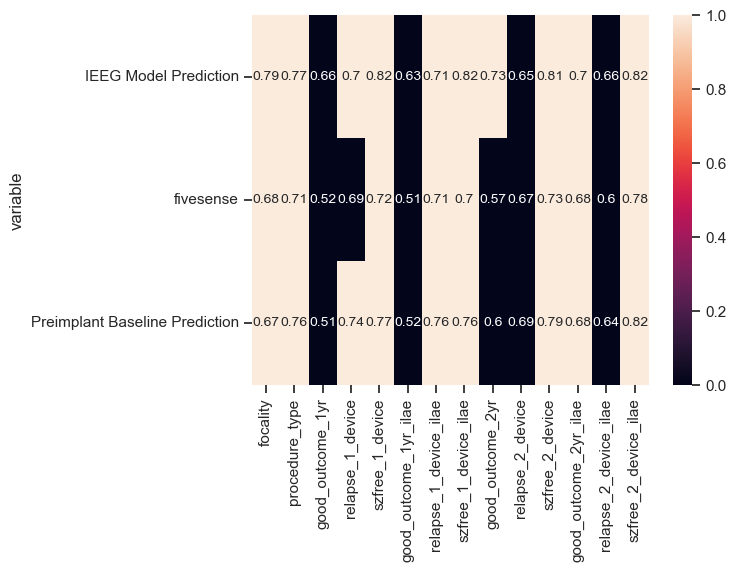

In [125]:
sns.heatmap(
    metric_scores.xs("ranksum", level="metric") < 0.05,
    annot=metric_scores.xs("roc", level="metric"),
    annot_kws={"size": 10},
)

In [126]:
metric_scores

,,focality,procedure_type,good_outcome_1yr,relapse_1_device,szfree_1_device,good_outcome_1yr_ilae,relapse_1_device_ilae,szfree_1_device_ilae,good_outcome_2yr,relapse_2_device,szfree_2_device,good_outcome_2yr_ilae,relapse_2_device_ilae,szfree_2_device_ilae
variable,metric,,,,,,,,,,,,,,
IEEG Model Prediction,cohend,-1.125532,-1.079078,-0.563056,-0.756752,-1.317222,-0.48443,-0.822727,-1.324082,-0.759982,-0.558486,-1.256053,-0.69305,-0.630792,-1.276484
fivesense,cohend,-0.638013,-0.794513,-0.072896,-0.704384,-0.835946,0.080327,-0.821999,-0.751428,-0.239873,-0.596174,-0.90788,-0.661486,-0.369922,-1.129204
Preimplant Baseline Prediction,cohend,-0.655876,-1.038579,-0.084368,-0.895145,-1.074641,0.015327,-0.989902,-0.992724,-0.387917,-0.687724,-1.152724,-0.721076,-0.529606,-1.359535
IEEG Model Prediction,u-stat,490.0,271.0,222.0,104.0,125.0,254.0,126.0,103.0,157.0,106.0,129.0,185.0,121.0,114.0
fivesense,u-stat,759.0,336.0,312.0,107.5,193.5,350.5,125.5,172.5,248.0,101.0,185.0,201.0,145.0,141.0
Preimplant Baseline Prediction,u-stat,762.0,275.0,317.0,89.0,156.0,357.0,104.0,139.0,232.0,95.0,145.0,198.0,130.0,110.0
IEEG Model Prediction,ranksum,0.000001,0.000497,0.062538,0.043308,0.000127,0.10435,0.020078,0.000196,0.009672,0.131899,0.000169,0.015001,0.084981,0.000156
fivesense,ranksum,0.003595,0.005989,0.832735,0.055471,0.008772,0.928438,0.019308,0.021508,0.433143,0.094411,0.005581,0.033156,0.306762,0.001074
Preimplant Baseline Prediction,ranksum,0.00386,0.000588,0.905061,0.013267,0.001026,0.836494,0.003966,0.00283,0.271176,0.061359,0.000505,0.028865,0.144362,0.000115


In [127]:
GoodOutcome2 = (
    # (Surg_Outcomes["2 years.1"].dropna() == 1)
    # &
    (Surg_Outcomes["2 years"].dropna() == 1)
    # & (GoodOutcome1)
).rename("good_outcome_2yr")

group
good outcome    33
poor outcome    19
device          19
Name: count, dtype: int64


/tmp/ipykernel_43284/347674960.py:31: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


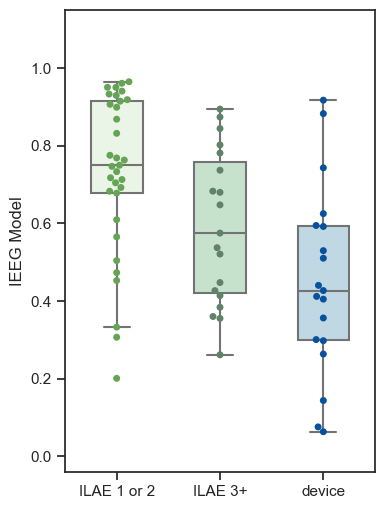

In [128]:
Fig2Data = pd.concat(
    [
        X.join(
            GoodOutcome2.map({True: "good outcome", False: "poor outcome"}).rename(
                "group"
            ),
            how="inner",
        ),
        X.join(
            type_of_proc[type_of_proc.isin(["device"])].rename("group"), how="inner"
        ),
    ],
    keys=["proc_type", "outcome"],
    names=["sep"],
).reset_index("sep")
print(Fig2Data["group"].value_counts())

plt.figure(figsize=(4, 6))
ax = sns.boxplot(
    data=Fig2Data,
    x="group",
    y="IEEG Model Prediction",
    palette=sns.color_palette(["#e0f3db", "#a8ddb5", "#9ecae1"]),
    order=["good outcome", "poor outcome", "device"],
    width=0.5,
    showfliers=False,
)
for art in ax.patches:
    r, g, b, a = art.get_facecolor()
    art.set_facecolor((r, g, b, 0.7))
sns.swarmplot(
    data=Fig2Data,
    x="group",
    y="IEEG Model Prediction",
    palette=sns.color_palette(["#65a355", "#608269", "#08519c"]),
    order=["good outcome", "poor outcome", "device"],
)

plt.xlabel("")
plt.ylim(-0.04, 1.15)
plt.yticks(np.linspace(0, 1, 6))
plt.ylabel("IEEG Model")
ticks, lbls = plt.xticks()
plt.xticks(ticks, ["ILAE 1 or 2", "ILAE 3+", "device"])
plt.savefig(ospj(figpath, "outcomes_ieeg_ilae.pdf"), bbox_inches="tight")
fig.show()

/tmp/ipykernel_43284/1662604787.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


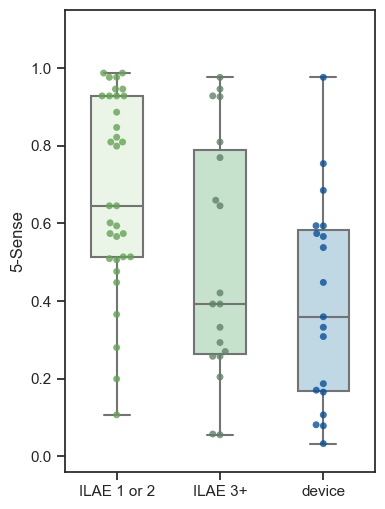

In [129]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(
    data=Fig2Data,
    x="group",
    y="fivesense",
    palette=sns.color_palette(["#e0f3db", "#a8ddb5", "#9ecae1"]),
    order=["good outcome", "poor outcome", "device"],
    width=0.5,
    showfliers=False,
)
for art in ax.patches:
    r, g, b, a = art.get_facecolor()
    art.set_facecolor((r, g, b, 0.7))
sns.swarmplot(
    data=Fig2Data,
    x="group",
    y="fivesense",
    palette=sns.color_palette(["#65a355", "#608269", "#08519c"]),
    order=["good outcome", "poor outcome", "device"],
    alpha=0.8,
)
plt.xlabel("")
plt.ylim(-0.04, 1.15)
plt.ylabel("Post Test Probability")
plt.ylabel("5-Sense")
ticks, lbls = plt.xticks()
plt.xticks(ticks, ["ILAE 1 or 2", "ILAE 3+", "device"])
plt.savefig(ospj(figpath, "outcomes_5sense_ilae.pdf"), bbox_inches="tight")
plt.show()

/tmp/ipykernel_43284/2295135638.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


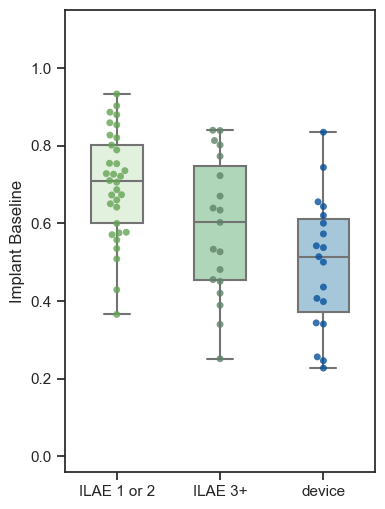

In [130]:
plt.figure(figsize=(4, 6))
Ax = sns.boxplot(
    data=Fig2Data,
    x="group",
    y="Preimplant Baseline Prediction",
    palette=sns.color_palette(["#e0f3db", "#a8ddb5", "#9ecae1"]),
    order=["good outcome", "poor outcome", "device"],
    width=0.5,
    showfliers=False,
)
for art in ax.patches:
    r, g, b, a = art.get_facecolor()
    art.set_facecolor((r, g, b, 0.7))
sns.swarmplot(
    data=Fig2Data,
    x="group",
    y="Preimplant Baseline Prediction",
    palette=sns.color_palette(["#65a355", "#608269", "#08519c"]),
    order=["good outcome", "poor outcome", "device"],
    alpha=0.8,
)
plt.ylabel("Implant Baseline")
plt.ylim(-0.04, 1.15)
plt.yticks(np.linspace(0, 1, 6))
plt.xlabel("")
ticks, lbls = plt.xticks()
plt.xticks(ticks, ["ILAE 1 or 2", "ILAE 3+", "device"])
plt.savefig(ospj(figpath, "outcomes_baseline_ilae.pdf"), bbox_inches="tight")
plt.show()

In [131]:
GoodOutcome2 = (
    (Surg_Outcomes["2 years.1"].dropna() == 1)
    # &
    # (Surg_Outcomes["2 years"].dropna() == 1)
    # & (GoodOutcome1)
).rename("good_outcome_2yr")

group
good outcome    36
device          19
poor outcome    16
Name: count, dtype: int64


/tmp/ipykernel_43284/2434733605.py:31: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


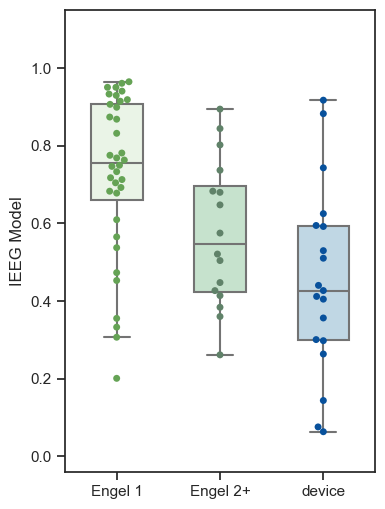

In [132]:
Fig2Data = pd.concat(
    [
        X.join(
            GoodOutcome2.map({True: "good outcome", False: "poor outcome"}).rename(
                "group"
            ),
            how="inner",
        ),
        X.join(
            type_of_proc[type_of_proc.isin(["device"])].rename("group"), how="inner"
        ),
    ],
    keys=["proc_type", "outcome"],
    names=["sep"],
).reset_index("sep")
print(Fig2Data["group"].value_counts())

plt.figure(figsize=(4, 6))
ax = sns.boxplot(
    data=Fig2Data,
    x="group",
    y="IEEG Model Prediction",
    palette=sns.color_palette(["#e0f3db", "#a8ddb5", "#9ecae1"]),
    order=["good outcome", "poor outcome", "device"],
    width=0.5,
    showfliers=False,
)
for art in ax.patches:
    r, g, b, a = art.get_facecolor()
    art.set_facecolor((r, g, b, 0.7))
sns.swarmplot(
    data=Fig2Data,
    x="group",
    y="IEEG Model Prediction",
    palette=sns.color_palette(["#65a355", "#608269", "#08519c"]),
    order=["good outcome", "poor outcome", "device"],
)

plt.xlabel("")
plt.ylim(-0.04, 1.15)
plt.yticks(np.linspace(0, 1, 6))
plt.ylabel("IEEG Model")
ticks, lbls = plt.xticks()
plt.xticks(ticks, ["Engel 1", "Engel 2+", "device"])
plt.savefig(ospj(figpath, "outcomes_ieeg.pdf"), bbox_inches="tight")
fig.show()

/tmp/ipykernel_43284/255200979.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


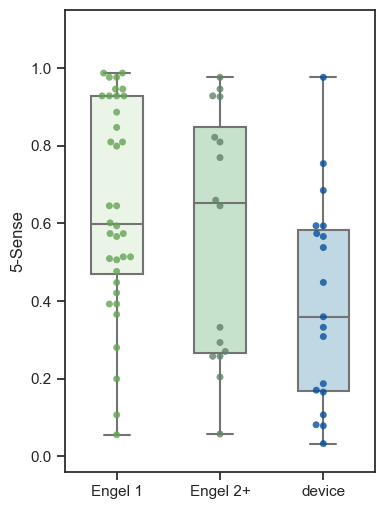

In [133]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(
    data=Fig2Data,
    x="group",
    y="fivesense",
    palette=sns.color_palette(["#e0f3db", "#a8ddb5", "#9ecae1"]),
    order=["good outcome", "poor outcome", "device"],
    width=0.5,
    showfliers=False,
)
for art in ax.patches:
    r, g, b, a = art.get_facecolor()
    art.set_facecolor((r, g, b, 0.7))
sns.swarmplot(
    data=Fig2Data,
    x="group",
    y="fivesense",
    palette=sns.color_palette(["#65a355", "#608269", "#08519c"]),
    order=["good outcome", "poor outcome", "device"],
    alpha=0.8,
)
plt.xlabel("")
plt.ylim(-0.04, 1.15)
plt.ylabel("Post Test Probability")
plt.ylabel("5-Sense")
ticks, lbls = plt.xticks()
plt.xticks(ticks, ["Engel 1", "Engel 2+", "device"])
plt.savefig(ospj(figpath, "outcomes_5s.pdf"), bbox_inches="tight")
plt.show()

/tmp/ipykernel_43284/2552518158.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


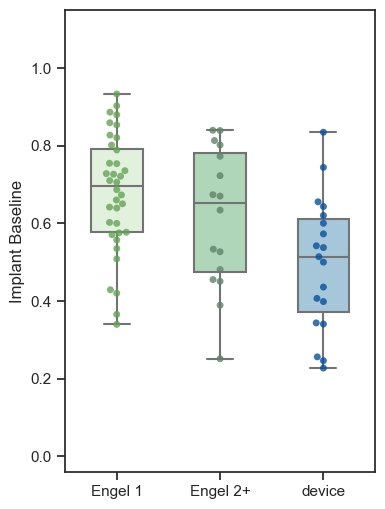

In [134]:
plt.figure(figsize=(4, 6))
Ax = sns.boxplot(
    data=Fig2Data,
    x="group",
    y="Preimplant Baseline Prediction",
    palette=sns.color_palette(["#e0f3db", "#a8ddb5", "#9ecae1"]),
    order=["good outcome", "poor outcome", "device"],
    width=0.5,
    showfliers=False,
)
for art in ax.patches:
    r, g, b, a = art.get_facecolor()
    art.set_facecolor((r, g, b, 0.7))
sns.swarmplot(
    data=Fig2Data,
    x="group",
    y="Preimplant Baseline Prediction",
    palette=sns.color_palette(["#65a355", "#608269", "#08519c"]),
    order=["good outcome", "poor outcome", "device"],
    alpha=0.8,
)
plt.ylabel("Implant Baseline")
plt.ylim(-0.04, 1.15)
plt.yticks(np.linspace(0, 1, 6))
plt.xlabel("")
ticks, lbls = plt.xticks()
plt.xticks(ticks, ["Engel 1", "Engel 2+", "device"])
plt.savefig(ospj(figpath, "outcomes_baseline.pdf"), bbox_inches="tight")
plt.show()

In [135]:
Fig2Data["group"].value_counts()

group
good outcome    36
device          19
poor outcome    16
Name: count, dtype: int64

In [136]:
## here differentiate between laser or resection

all_procs[
    [
        "Laser ablation",
        "Resection with intracranial implant",
        "Resection without intracranial implant",
    ]
].value_counts()
ablation_resection = all_procs[
    ["Laser ablation"] + [col for col in all_procs.columns if "Resection" in col]
].apply(
    lambda x: (
        "both"
        if x.sum() > 1
        else (
            "ablation"
            if x["Laser ablation"]
            else (
                "resection"
                if x["Resection with intracranial implant"]
                | x["Resection without intracranial implant"]
                else 0
            )
        )
    ),
    axis=1,
)

#### Make Table

In [137]:
N_chan_lat = (
    (
        AllBandChans.reset_index()
        .merge(LUT, left_on="label", right_on="roi_DKT")[
            ["patient", "focality", "channel", "x_mm", "y_mm", "z_mm", "lat"]
        ]
        .drop_duplicates()
    )
    .groupby(["patient", "focality"])["lat"]
    .value_counts()
    .unstack("lat")
    .droplevel("focality")
)
N_chan_lat["tot"] = N_chan_lat.sum(axis=1)
N_chan_lat["Implant"] = (
    N_chan_lat[["left", "right"]]
    .notna()
    .all(axis=1)
    .map({True: "Bilateral", False: "Unilateral"})
)

In [138]:
x1 = N_chan_lat[["tot"]].join(Y)
y1 = x1.pop("focality")

,cohend,u-stat,ranksum,roc,ci
variable,,,,,
tot,0.452296,1425.0,0.071031,0.608974,"(0.49653094406450027, 0.7214178503004289)"


(                                                   focality
 variable metric                                            
 tot      cohend                                    0.452296
          u-stat                                      1425.0
          ranksum                                   0.071031
          roc                                       0.608974
          ci       (0.49653094406450027, 0.7214178503004289),
 <Axes: xlabel='variable', ylabel='probability focal'>)

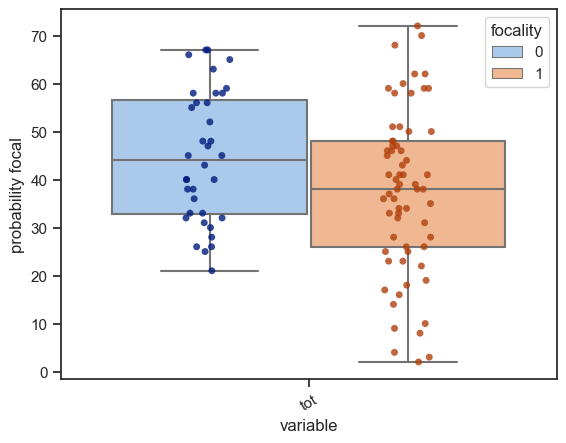

In [139]:
PrettyPictures(x1, y1)

In [140]:
SelectPatient = (
    X.join(Y).join(type_of_proc.rename("proc_type")).join(GoodOutcome).join(N_chan_lat)
)

In [141]:
from glob import glob

In [142]:
# for pt in tqdm(All_X.index.get_level_values("patient").values):
#     borel_path = "/users/rsg20/ieeg_recon/BIDS"
#     pt_subfolder = "sub-RID0" + f"{PreImplantData.loc[pt].RID:03n}"
#     write_folder = ospj(borel_path, pt_subfolder, "plots")
#     Pt_Electrode_ZScores = []
#     Feat_Names = []
#     pt_data = All_X.loc[pt]
#     for feat_name, val in pt_data.items():
#         if "_bp" in feat_name:
#             band = [b for b in band_names if b in feat_name][0]
#             clip_num = (
#                 BP_WSD_all_clips.loc[pt, band]
#                 .reset_index()
#                 .iloc[(BP_WSD_all_clips.loc[pt, band] - val).abs().to_numpy().argmin()][
#                     "clip"
#                 ]
#             )
#             Pt_Electrode_ZScores.append(
#                 AllBandChans.reset_index()
#                 .query(
#                     '(patient == @pt) & (band == @band) & (clip == @clip_num) & (period == "interictal")'
#                 )[["patient", "channel", "band", "absZScore"]]
#                 .merge(
#                     ChansToGet.set_index(["patient", "name"])[["x_mm", "y_mm", "z_mm"]],
#                     left_on=["patient", "channel"],
#                     right_index=True,
#                 )
#             )
#             Feat_Names.append(feat_name)
#         elif "_coh" in feat_name:
#             band = [b for b in band_names if b in feat_name][0]
#             clip_num = (
#                 Coh_WSD_all_clips.loc[pt, :, band]
#                 .reset_index()
#                 .iloc[
#                     (Coh_WSD_all_clips.loc[pt, :, band] - val).abs().to_numpy().argmin()
#                 ]["clip"]
#             )
#             Pt_Electrode_ZScores.append(
#                 Nxx_Chan_Stats.reset_index()
#                 .query("(patient == @pt) & (band == @band) & (clip == @clip_num)")
#                 .rename({0.75: "absZScore"}, axis=1)[
#                     ["patient", "channel", "band", "absZScore"]
#                 ]
#                 .merge(
#                     ChansToGet.set_index(["patient", "name"])[["x_mm", "y_mm", "z_mm"]],
#                     left_on=["patient", "channel"],
#                     right_index=True,
#                 )
#             )
#             Feat_Names.append(feat_name)
#         PtChanData = (
#             pd.concat(Pt_Electrode_ZScores, keys=Feat_Names, names=["Features"])
#             .droplevel(-1)
#             .reset_index()
#         )
#         PtChanData.to_csv(ospj(data_path, pt, "plot_abnormality.csv"))
#     for feat, feat_score in PtChanData.groupby("Features"):
#         node_file = feat_score.loc[:, ["x_mm", "y_mm", "z_mm", "absZScore"]]
#         node_file["absZScore"] = node_file["absZScore"].mask(lambda x: x > 3.5, 3.5)
#         node_file["size"] = node_file["absZScore"]
#         node_file["label"] = feat_score["channel"]
#         node_file = node_file[["x_mm", "y_mm", "z_mm", "absZScore", "size", "label"]]
#         if not os.path.exists(write_folder):
#             os.mkdir(write_folder)
#         node_file.to_csv(
#             ospj(write_folder, f"{feat}.node"),
#             sep=" ",
#             header=False,
#             index=False,
#             index_label=False,
#         )

In [143]:
Pivot = (
    SelectPatient.join(
        (
            outcomes["Type of Implant: "].dropna()
            == "Stereo EEG (Depths ONLY, do not check Depths)"
        )
        .map({True: "stereo", False: "grid/strip/depth"})
        .rename("stereo EEG")
    )
    .join(ablation_resection.rename("abl_res"))
    .join(outcomes[["Gender", "Age of Epilepsy onset (in years)", "Age at implant"]])
    .join(FiveSenseDf[[col for col in FiveSenseDf.columns if "MRI" in col]])
    .join(Surg_Outcomes)
    .reset_index()
)
Pivot

,patient,Preimplant Baseline Prediction,IEEG Model Prediction,fivesense,focality,proc_type,good_outcome_1yr_ilae,good_outcome_2yr_ilae,left,right,...,Gender,Age of Epilepsy onset (in years),Age at implant,MRI_focal,MRI_nolesion,MRI_nonfocal,1 year.1,2 years.1,1 year,2 years
0,HUP064,0.859088,0.899021,0.928262,1,surgery,False,True,51.0,NaN,...,Male (1),3.0,21.0,True,False,False,1.0,1.0,0.0,1.0
1,HUP065,0.639331,0.781111,0.420749,1,surgery,True,False,NaN,45.0,...,Male (1),23.0,37.0,False,False,True,1.0,1.0,1.0,0.0
2,HUP068,0.534840,0.592097,0.420749,1,surgery,NaN,NaN,4.0,42.0,...,Female (2),15.0,28.0,False,False,True,NaN,NaN,NaN,NaN
3,HUP070,0.726578,0.677801,0.593511,1,surgery,True,True,40.0,NaN,...,Male (1),10.0,33.0,False,True,False,1.0,1.0,1.0,1.0
4,HUP073,0.508355,0.306644,0.447717,0,surgery,False,True,18.0,14.0,...,Male (1),12.0,39.0,False,True,False,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,HUP210,0.736966,0.745623,0.809490,0,none,NaN,NaN,66.0,1.0,...,Male (1),12.0,29.0,False,True,False,NaN,NaN,NaN,NaN
97,HUP213,0.762654,0.752541,0.847018,0,none,NaN,NaN,40.0,NaN,...,Male (1),2.0,21.0,True,False,False,NaN,NaN,NaN,NaN
98,HUP215,0.790696,0.769747,0.506025,1,surgery,NaN,NaN,38.0,NaN,...,Male (1),30.0,36.0,True,False,False,NaN,NaN,NaN,NaN
99,HUP216,0.553171,0.318973,0.602286,1,surgery,NaN,NaN,40.0,19.0,...,Female (2),3.0,21.0,False,True,False,NaN,NaN,NaN,NaN


In [144]:
Pivot["Age at implant"]

0      21.0
1      37.0
2      28.0
3      33.0
4      39.0
       ... 
96     29.0
97     21.0
98     36.0
99     21.0
100    49.0
Name: Age at implant, Length: 101, dtype: float64

In [145]:
Pivot.pivot_table(
    columns="focality",
    index=["proc_type"],
    values="patient",
    aggfunc="count",
    dropna=False,
    fill_value=0,
    margins=True,
)

focality,0,1,All
proc_type,,,
both,1,2,3
device,14,5,19
none,10,7,17
surgery,10,51,61
All,36,65,101


In [146]:
Pivot.pivot_table(
    columns="focality",
    index=[
        "stereo EEG",
        "proc_type",
    ],
    values="patient",
    aggfunc="count",
    dropna=False,
    fill_value=0,
    margins=True,
)

focality                     0   1  All
stereo EEG       proc_type             
grid/strip/depth both        1   1    2
                 device      4   1    5
                 none        1   1    2
                 surgery     2  23   25
stereo           both        0   1    1
                 device     10   4   14
                 none        9   6   15
                 surgery     8  28   36
All                         36  65  101

In [147]:
Pivot.columns

Index(['patient', 'Preimplant Baseline Prediction', 'IEEG Model Prediction',
       'fivesense', 'focality', 'proc_type', 'good_outcome_1yr_ilae',
       'good_outcome_2yr_ilae', 'left', 'right', 'tot', 'Implant',
       'stereo EEG', 'abl_res', 'Gender', 'Age of Epilepsy onset (in years)',
       'Age at implant', 'MRI_focal', 'MRI_nolesion', 'MRI_nonfocal',
       '1 year.1', '2 years.1', '1 year', '2 years'],
      dtype='object')

In [148]:
print(Pivot.groupby("focality")["tot"].describe())
mannwhitneyu(
    *[group.dropna().to_numpy() for _, group in Pivot.groupby("focality")["tot"]]
)

          count       mean        std   min    25%   50%   75%   max
focality                                                            
0          36.0  44.583333  13.664082  21.0  32.75  44.0  56.5  67.0
1          65.0  37.415385  16.923442   2.0  26.00  38.0  48.0  72.0


MannwhitneyuResult(statistic=1425.0, pvalue=0.07103060353370451)

In [149]:
from scipy.stats import chi2_contingency

In [150]:
chi2_contingency([[4, 33], [5, 29]])

Chi2ContingencyResult(statistic=0.018433637622442278, pvalue=0.8920026866012325, dof=1, expected_freq=array([[ 4.69014085, 32.30985915],
       [ 4.30985915, 29.69014085]]))

In [151]:
# chi2_contingency(
Pivot.pivot_table(
    columns="focality",
    index=[
        "2 years.1",
    ],
    values="patient",
    aggfunc="count",
    dropna=False,
    # fill_value=0,
    # margins=True,
)
# )

focality,0,1
2 years.1,,
0.0,2,14
1.0,6,30


In [152]:
Pivot.pivot_table(
    columns="focality",
    index=["stereo EEG", "abl_res", "good_outcome_2yr_ilae"],
    values="patient",
    aggfunc="count",
    dropna=False,
    fill_value=0,
    margins=True,
)

focality                                           0   1    All
stereo EEG       abl_res   good_outcome_2yr_ilae               
grid/strip/depth ablation  False                   0   0    NaN
                           True                    0   2    2.0
                 resection False                   0   5    5.0
                           True                    2  15   17.0
                 both      False                   0   0    NaN
                           True                    0   0    NaN
stereo           ablation  False                   2   7    9.0
                           True                    2   8   10.0
                 resection False                   1   3    4.0
                           True                    1   3    4.0
                 both      False                   0   1    1.0
                           True                    0   0    NaN
All                                               36  65  101.0

<Axes: xlabel='stereo EEG', ylabel='n_chans'>

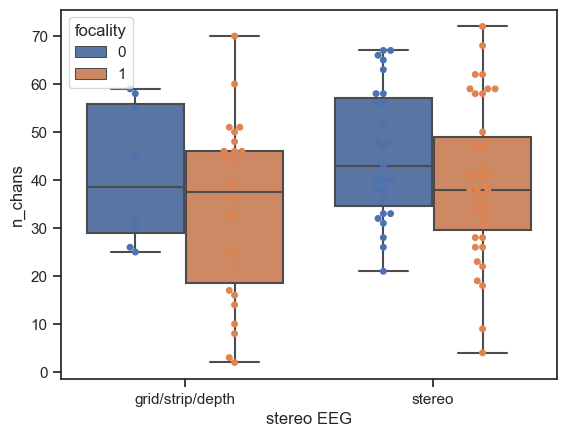

In [153]:
sns.swarmplot(
    data=Pivot.set_index("patient").join(
        AllBandChans.reset_index()[["patient", "channel", "soz"]]
        .drop_duplicates()
        .groupby("patient")["channel"]
        .count()
        .rename("n_chans")
    ),
    x="stereo EEG",
    y="n_chans",
    hue="focality",
    dodge=True,
    legend=False,
)
sns.boxplot(
    data=Pivot.set_index("patient").join(
        AllBandChans.reset_index()[["patient", "channel", "soz"]]
        .drop_duplicates()
        .groupby("patient")["channel"]
        .count()
        .rename("n_chans")
    ),
    x="stereo EEG",
    y="n_chans",
    hue="focality",
)

#### Subanalysis on grids/strips vs stereo

In [154]:
outcomes["seeg"] = (
    outcomes["Type of Implant: "].dropna()
    == "Stereo EEG (Depths ONLY, do not check Depths)"
)

In [155]:
X.join(outcomes["Type of Implant: "])["Type of Implant: "].value_counts()

Type of Implant: 
Stereo EEG (Depths ONLY, do not check Depths)    66
Grids,Strips,Depths (not Stereo EEG)             21
Strips,Depths (not Stereo EEG)                    7
Grids,Strips                                      4
Strips                                            1
Grids,Depths (not Stereo EEG)                     1
Name: count, dtype: int64

In [156]:
GridStereo = (
    X.join(
        (
            outcomes["Type of Implant: "].dropna()
            == "Stereo EEG (Depths ONLY, do not check Depths)"
        )
        .map({False: "grid/strip/depth", True: "seeg"})
        .rename("stereo EEG"),
        how="inner",
    )
    .join(y)
    .join(Base_SD.droplevel("focality"), how="inner")
)
# GridStereo['stereo EEG']=GridStereo['stereo EEG'].map({True:'seeg', False:'grid/strip/depth'})

In [157]:
GridStereo

,Preimplant Baseline Prediction,IEEG Model Prediction,fivesense,stereo EEG,focality,Unweighted
HUP064,0.859088,0.899021,0.928262,grid/strip/depth,1,33.256856
HUP065,0.639331,0.781111,0.420749,grid/strip/depth,1,36.160024
HUP068,0.534840,0.592097,0.420749,grid/strip/depth,1,46.428711
HUP070,0.726578,0.677801,0.593511,grid/strip/depth,1,33.016668
HUP073,0.508355,0.306644,0.447717,grid/strip/depth,0,51.479348
...,...,...,...,...,...,...
HUP210,0.736966,0.745623,0.809490,seeg,0,43.412872
HUP213,0.762654,0.752541,0.847018,seeg,0,42.908261
HUP215,0.790696,0.769747,0.506025,seeg,1,20.614629
HUP216,0.553171,0.318973,0.602286,seeg,1,50.982331


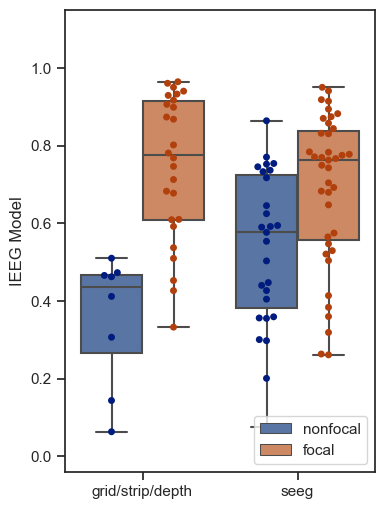

In [158]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=GridStereo,
    y="IEEG Model Prediction",
    x="stereo EEG",
    hue="focality",
    palette="dark",
    legend=False,
    dodge=True,
)
ax = sns.boxplot(
    data=GridStereo,
    y="IEEG Model Prediction",
    x="stereo EEG",
    hue="focality",
    palette="deep",
    dodge=True,
)
plt.xlabel("")
plt.ylabel("IEEG Model")
plt.ylim(-0.04, 1.15)
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["nonfocal", "focal"], loc="lower right")
plt.savefig(ospj(figpath, "seeg_ieeg.pdf"), bbox_inches="tight")

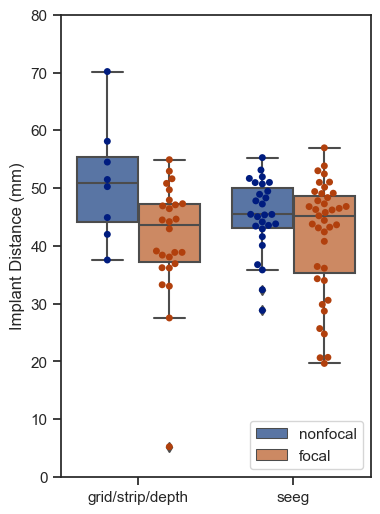

In [159]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=GridStereo,
    y="Unweighted",
    x="stereo EEG",
    hue="focality",
    palette="dark",
    legend=False,
    dodge=True,
)
ax = sns.boxplot(
    data=GridStereo,
    y="Unweighted",
    x="stereo EEG",
    hue="focality",
    palette="deep",
    dodge=True,
)
plt.ylabel("Implant Distance (mm)")
plt.ylim(0, 80)
plt.xlabel("")
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["nonfocal", "focal"], loc="lower right")
plt.savefig(ospj(figpath, "seeg_distance.pdf"), bbox_inches="tight")

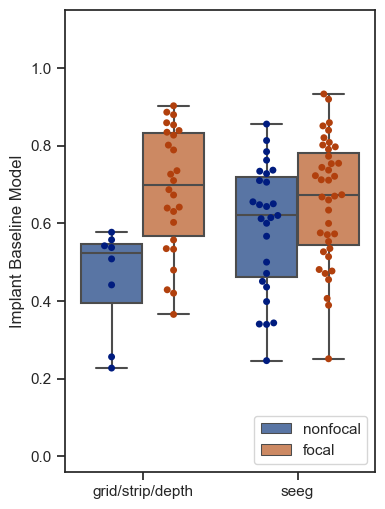

In [160]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=GridStereo,
    y="Preimplant Baseline Prediction",
    x="stereo EEG",
    hue="focality",
    palette="dark",
    legend=False,
    dodge=True,
)
ax = sns.boxplot(
    data=GridStereo,
    y="Preimplant Baseline Prediction",
    x="stereo EEG",
    hue="focality",
    palette="deep",
    dodge=True,
)
plt.ylabel("Implant Baseline Model")
plt.ylim(-0.04, 1.15)
plt.xlabel("")
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["nonfocal", "focal"], loc="lower right")
plt.savefig(ospj(figpath, "seeg_baseline.pdf"), bbox_inches="tight")

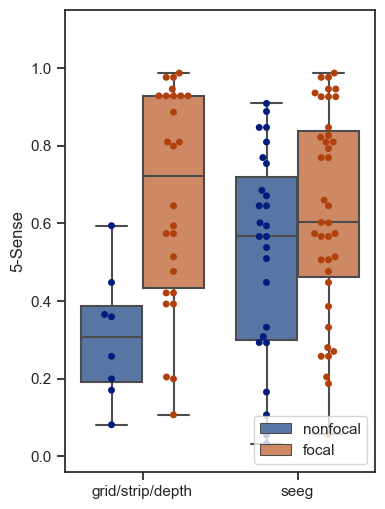

In [161]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=GridStereo,
    y="fivesense",
    x="stereo EEG",
    hue="focality",
    palette="dark",
    legend=False,
    dodge=True,
)
ax = sns.boxplot(
    data=GridStereo,
    y="fivesense",
    x="stereo EEG",
    hue="focality",
    palette="deep",
    dodge=True,
)
plt.ylabel("5-Sense")
plt.ylim(-0.04, 1.15)
plt.xlabel("")
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["nonfocal", "focal"], loc="lower right")
plt.savefig(ospj(figpath, "seeg_5s.pdf"), bbox_inches="tight")

In [162]:
subX = GridStereo[GridStereo["stereo EEG"] == "seeg"].drop("stereo EEG", axis=1)
subY = subX.pop("focality")

,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-0.796591,284.0,0.001599,0.730294,"(0.6095122009729639, 0.8510766118551001)"
Preimplant Baseline Prediction,-0.426021,396.0,0.089992,0.623932,"(0.4862524325995239, 0.7616107408852784)"
fivesense,-0.411015,409.5,0.128517,0.611111,"(0.47393985139407535, 0.7482823575826703)"
Unweighted,0.404759,608.0,0.290790,0.577398,"(0.4382253203414642, 0.7165704455353058)"


(                                                                         focality
 variable                       metric                                            
 IEEG Model Prediction          cohend                                   -0.796591
 Preimplant Baseline Prediction cohend                                   -0.426021
 fivesense                      cohend                                   -0.411015
 Unweighted                     cohend                                    0.404759
 IEEG Model Prediction          u-stat                                       284.0
 Preimplant Baseline Prediction u-stat                                       396.0
 fivesense                      u-stat                                       409.5
 Unweighted                     u-stat                                       608.0
 IEEG Model Prediction          ranksum                                   0.001599
 Preimplant Baseline Prediction ranksum                                   0.089992
 fiv

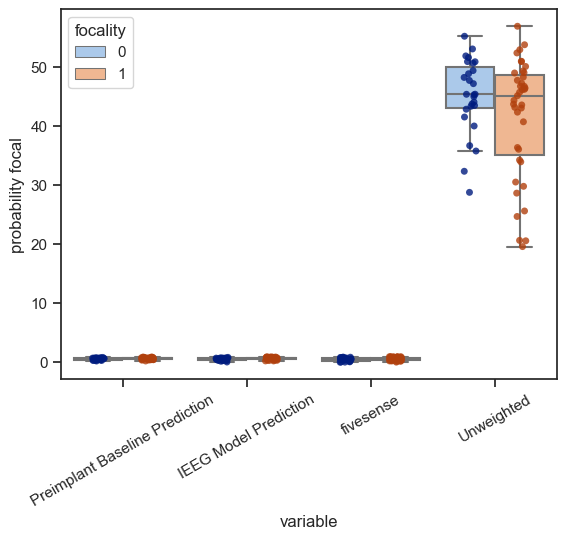

In [163]:
PrettyPictures(subX, subY)

In [164]:
subX = GridStereo[GridStereo["stereo EEG"] != "seeg"].drop("stereo EEG", axis=1)
subY = subX.pop("focality")

,cohend,u-stat,ranksum,roc,ci
variable,,,,,
IEEG Model Prediction,-2.125828,14.0,0.000051,0.932692,"(0.8512151059943973, 1.0141694727104367)"
Preimplant Baseline Prediction,-1.483433,33.0,0.002771,0.841346,"(0.7082577252674394, 0.9744348025035567)"
fivesense,-1.391974,30.5,0.002981,0.853365,"(0.7151021733614893, 0.9916286692288427)"
Unweighted,0.975099,157.0,0.031027,0.754808,"(0.5464272753875172, 0.9631881459076488)"


(                                                                        focality
 variable                       metric                                           
 IEEG Model Prediction          cohend                                  -2.125828
 Preimplant Baseline Prediction cohend                                  -1.483433
 fivesense                      cohend                                  -1.391974
 Unweighted                     cohend                                   0.975099
 IEEG Model Prediction          u-stat                                       14.0
 Preimplant Baseline Prediction u-stat                                       33.0
 fivesense                      u-stat                                       30.5
 Unweighted                     u-stat                                      157.0
 IEEG Model Prediction          ranksum                                  0.000051
 Preimplant Baseline Prediction ranksum                                  0.002771
 fivesense      

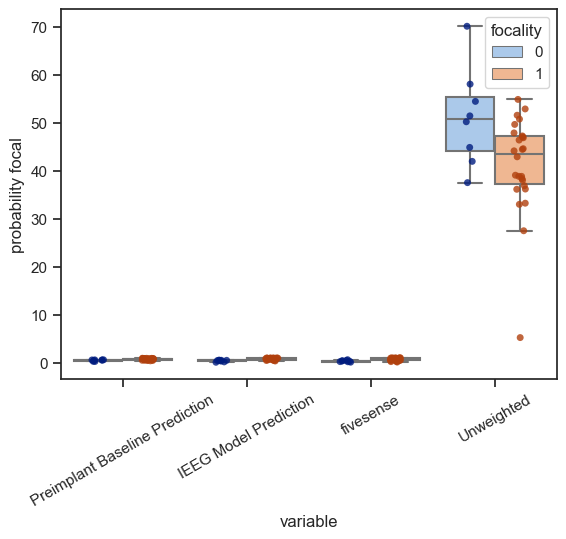

In [165]:
PrettyPictures(subX, subY)

In [166]:
Fig2Data = pd.concat(
    [
        subX.join(
            GoodOutcome2.map({True: "good outcome", False: "poor outcome"}).rename(
                "group"
            ),
            how="inner",
        ),
        subX.join(
            type_of_proc[type_of_proc.isin(["surgery", "device"])].rename("group"),
            how="inner",
        ),
    ],
    keys=["proc_type", "outcome"],
    names=["sep"],
).reset_index("sep")

#### subanalysis by type

In [167]:
breakdown = X.join(PreImplantData[target_col]).join(
    Base_SD.droplevel("focality"), how="inner"
)
breakdown[target_col] = (
    breakdown[target_col]
    .mask(lambda x: x == "multifocal", "broad")
    .cat.rename_categories({"broad": "broad/multifocal"})
    .cat.remove_unused_categories()
)

In [168]:
breakdown

,Preimplant Baseline Prediction,IEEG Model Prediction,fivesense,postimplant_soz,Unweighted
patient,,,,,
HUP064,0.859088,0.899021,0.928262,unifocal,33.256856
HUP065,0.639331,0.781111,0.420749,unifocal,36.160024
HUP068,0.534840,0.592097,0.420749,unifocal,46.428711
HUP070,0.726578,0.677801,0.593511,unifocal,33.016668
HUP073,0.508355,0.306644,0.447717,broad/multifocal,51.479348
...,...,...,...,...,...
HUP210,0.736966,0.745623,0.809490,broad/multifocal,43.412872
HUP213,0.762654,0.752541,0.847018,broad/multifocal,42.908261
HUP215,0.790696,0.769747,0.506025,unifocal,20.614629


In [169]:
test_results = []
roc_curves = []
for var, group in breakdown.melt(id_vars=target_col, ignore_index=False).groupby(
    "variable"
):
    for x, y in itertools.combinations(group.groupby(target_col), 2):
        roc = group[group[target_col].isin([x[0], y[0]])]
        roc[target_col] = roc[target_col].map({x[0]: 1, y[0]: 0})
        test_results.append(
            (
                var,
                x[0],
                y[0],
                mannwhitneyu(x[1]["value"], y[1]["value"])[1],
                real_roc(roc[target_col], roc["value"])[0],
                real_roc(roc[target_col], roc["value"])[1],
            )
        )

/tmp/ipykernel_43284/2493484138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc[target_col] = roc[target_col].map({x[0]: 1, y[0]: 0})
/tmp/ipykernel_43284/2493484138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc[target_col] = roc[target_col].map({x[0]: 1, y[0]: 0})
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10/site-packages/confidenceinterval/delong.py:173: RuntimeWarning: Degrees of freedom <= 0 for slice
  sy = np.cov(v10)
/users/rsg20/miniconda3/envs/ieegpy_test/lib/python3.10

/tmp/ipykernel_43284/525694920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc[target_col] = roc[target_col].apply(lambda x: 1 if x == "unifocal" else 0)
/tmp/ipykernel_43284/525694920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc[target_col] = roc[target_col].apply(lambda x: 1 if x == "unifocal" else 0)


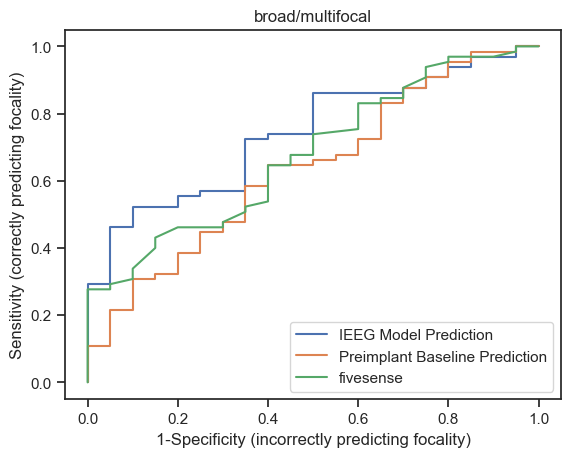

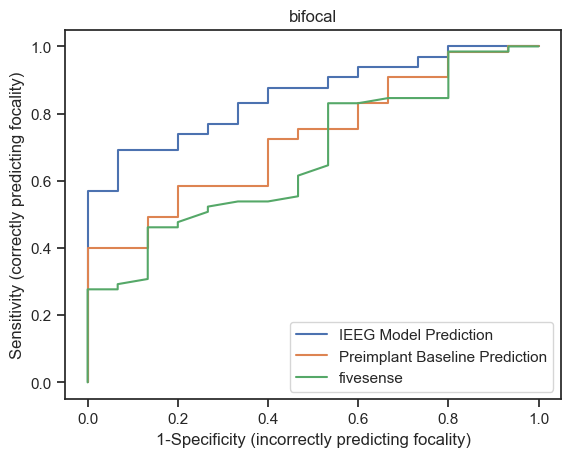

In [170]:
plt.close("all")
for SubType in ["broad/multifocal", "bifocal"]:
    plt.figure()
    plt.title(SubType)
    roc = breakdown[breakdown[target_col].isin(["unifocal", SubType])]
    roc[target_col] = roc[target_col].apply(lambda x: 1 if x == "unifocal" else 0)
    for var, group in roc.melt(id_vars=target_col, ignore_index=False).groupby(
        "variable"
    ):
        if var != "Unweighted":
            fpr, tpr, thresh = metrics.roc_curve(group[target_col], group["value"])
            plt.plot(fpr, tpr, label=var)
    plt.ylabel("Sensitivity (correctly predicting focality)")
    plt.xlabel("1-Specificity (incorrectly predicting focality)")
    # fpr, tpr,thresh = metrics.roc_curve(y_all.values, All_X['fivesense'].values)
    # plt.plot(fpr, tpr,label='Five Sense')
    plt.legend(loc="lower right")
    plt.savefig(ospj(figpath, f"{SubType[:4]}_roc.pdf"), bbox_inches="tight")

In [171]:
test_results = pd.DataFrame(
    test_results, columns=["variable", "group1", "group2", "p", "roc", "ci"]
)[
    lambda x: x["group1"].isin(["bifocal", "broad/multifocal", "unifocal"])
    & x["group2"].isin(["bifocal", "broad/multifocal", "unifocal"])
]
test_results

,variable,group1,group2,p,roc,ci
0,IEEG Model Prediction,bifocal,broad/multifocal,0.080118,0.676667,"(0.49600780924571064, 0.857325604355211)"
2,IEEG Model Prediction,bifocal,unifocal,0.000022,0.853333,"(0.7651642488047907, 0.9415023995831182)"
4,IEEG Model Prediction,broad/multifocal,unifocal,0.001250,0.740000,"(0.6266158865144462, 0.8533841325590401)"
6,Preimplant Baseline Prediction,bifocal,broad/multifocal,0.342112,0.596667,"(0.4047187287092655, 0.7886144798516781)"
8,Preimplant Baseline Prediction,bifocal,unifocal,0.006691,0.726154,"(0.5986160415246038, 0.853691659586236)"
10,Preimplant Baseline Prediction,broad/multifocal,unifocal,0.065924,0.636923,"(0.49801770808207624, 0.7758285605717934)"
12,Unweighted,bifocal,broad/multifocal,0.034288,0.713333,"(0.535596306540423, 0.8910704300623602)"
14,Unweighted,bifocal,unifocal,0.003218,0.745641,"(0.6188576343986751, 0.8724244710471867)"
16,Unweighted,broad/multifocal,unifocal,0.728540,0.526154,"(0.3821338717313194, 0.6701738532213783)"
18,fivesense,bifocal,broad/multifocal,0.893900,0.515000,"(0.3130358352779592, 0.7169640765071665)"


In [172]:
for var, data in test_results.groupby("variable"):
    print(var)
    print(data)
    print(
        sm.stats.multipletests(
            data["p"],
            method="holm",
        )
    )

IEEG Model Prediction
                variable            group1            group2         p   
0  IEEG Model Prediction           bifocal  broad/multifocal  0.080118  \
2  IEEG Model Prediction           bifocal          unifocal  0.000022   
4  IEEG Model Prediction  broad/multifocal          unifocal  0.001250   

        roc                                        ci  
0  0.676667  (0.49600780924571064, 0.857325604355211)  
2  0.853333  (0.7651642488047907, 0.9415023995831182)  
4  0.740000  (0.6266158865144462, 0.8533841325590401)  
(array([False,  True,  True]), array([8.01183137e-02, 6.69440519e-05, 2.50003820e-03]), 0.016952427508441503, 0.016666666666666666)
Preimplant Baseline Prediction
                          variable            group1            group2   
6   Preimplant Baseline Prediction           bifocal  broad/multifocal  \
8   Preimplant Baseline Prediction           bifocal          unifocal   
10  Preimplant Baseline Prediction  broad/multifocal          unifocal  

/tmp/ipykernel_43284/3292764507.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


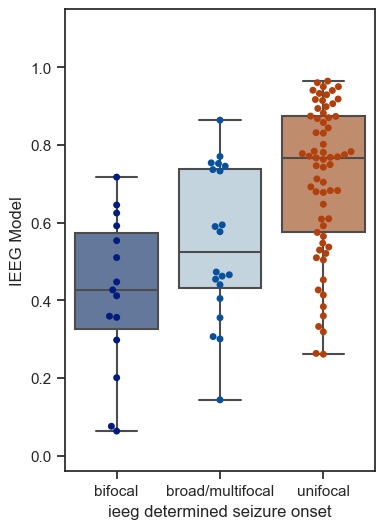

In [173]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=breakdown,
    y="IEEG Model Prediction",
    x=target_col,
    palette=sns.color_palette(["#001C7F", "#08519C", "#B1400D"]),
    legend=False,
    order=["bifocal", "broad/multifocal", "unifocal"],
)
ax = sns.boxplot(
    data=breakdown,
    y="IEEG Model Prediction",
    x=target_col,
    palette=sns.color_palette(["#5B75A4", "#C0D5E2", "#CC8961"]),
    order=["bifocal", "broad/multifocal", "unifocal"],
)
plt.xlabel("ieeg determined seizure onset")
plt.ylabel("IEEG Model")
plt.ylim(-0.04, 1.15)
plt.savefig(ospj(figpath, "type_ieeg.pdf"), bbox_inches="tight")

/tmp/ipykernel_43284/1027907876.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


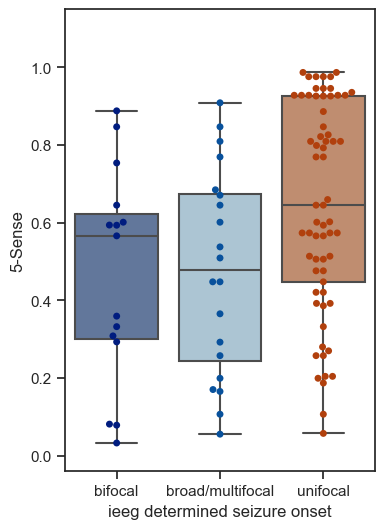

In [174]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=breakdown,
    y="fivesense",
    x=target_col,
    palette=sns.color_palette(["#001C7F", "#08519C", "#B1400D"]),
    legend=False,
    order=["bifocal", "broad/multifocal", "unifocal"],
)
ax = sns.boxplot(
    data=breakdown,
    y="fivesense",
    x=target_col,
    palette=sns.color_palette(["#5975A4", "#A6C7D9", "#CC8963"]),
    order=["bifocal", "broad/multifocal", "unifocal"],
)
plt.ylabel("5-Sense")
plt.xlabel("ieeg determined seizure onset")
plt.ylim(-0.04, 1.15)
plt.savefig(ospj(figpath, "type_5s.pdf"), bbox_inches="tight")

/tmp/ipykernel_43284/1723290645.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


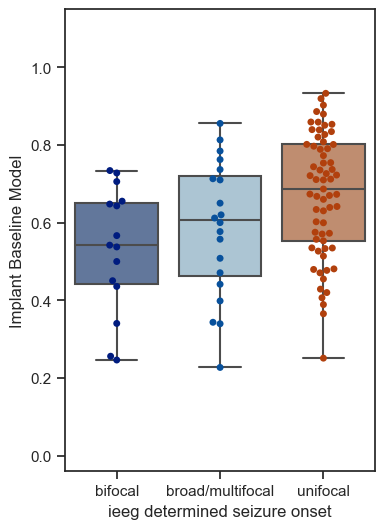

In [175]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=breakdown,
    y="Preimplant Baseline Prediction",
    x=target_col,
    palette=sns.color_palette(["#001C7F", "#08519C", "#B1400D"]),
    legend=False,
    order=["bifocal", "broad/multifocal", "unifocal"],
)
ax = sns.boxplot(
    data=breakdown,
    y="Preimplant Baseline Prediction",
    x=target_col,
    palette=sns.color_palette(["#5975A4", "#A6C7D9", "#CC8963"]),
    order=["bifocal", "broad/multifocal", "unifocal"],
)
plt.ylabel("Implant Baseline Model")
plt.ylim(-0.04, 1.15)
plt.xlabel("ieeg determined seizure onset")
plt.savefig(ospj(figpath, "type_baseline.pdf"), bbox_inches="tight")

/tmp/ipykernel_43284/614813078.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


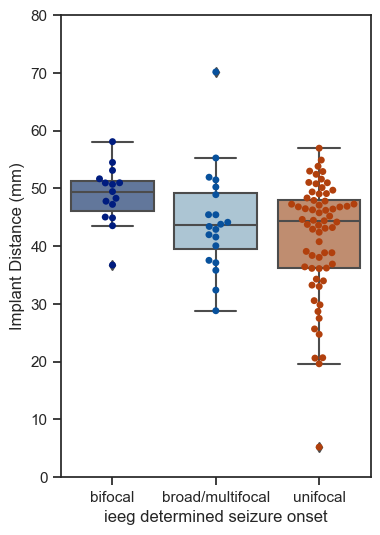

In [176]:
plt.figure(figsize=(4, 6))
sns.swarmplot(
    data=breakdown,
    y="Unweighted",
    x=target_col,
    palette=sns.color_palette(["#001C7F", "#08519C", "#B1400D"]),
    legend=False,
    order=["bifocal", "broad/multifocal", "unifocal"],
)
ax = sns.boxplot(
    data=breakdown,
    y="Unweighted",
    x=target_col,
    palette=sns.color_palette(["#5975A4", "#A6C7D9", "#CC8963"]),
    order=["bifocal", "broad/multifocal", "unifocal"],
)
plt.ylabel("Implant Distance (mm)")
plt.ylim(0, 80)
plt.xlabel("ieeg determined seizure onset")
plt.savefig(ospj(figpath, "type_dis.pdf"), bbox_inches="tight")

In [177]:
SelectPatient.index.unique().to_series().to_csv(ospj(metadata_path, "patient_list.csv"))